In [1]:
from random import sample
from tqdm.notebook import tqdm

import gym
from gym import spaces
from gym.utils import seeding

import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (12,5)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})

$\textbf{Замечания:}$ 
1. В моей версии AI GYM отсутствует Blackjack-v0. По этой причине использовалось окружение с 
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
2. В версии, взятой с GitHub неправильно работал механизм Natural (никогда не умножал выигрыш на 1.5). Исправил.

In [2]:
def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        super().__init__()
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()
        self.done = False
        self.player = []
        self.dealer = []
        self.reward = -1.0

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                self.done = True
                self.reward = -1.0
            else:
                self.done = False
                self.reward = 0.0
        else:  # stick: play out the dealers hand, and score
            self.done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            self.reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                self.reward = 1.0
            elif (
                not self.sab
                #and self.natural
                and is_natural(self.player)
                and self.reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                self.reward = 1.5
        return self._get_obs(), self.reward, self.done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.reward = -1.0
        self.done = False
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        if is_natural(self.player):
            self.step(0)
        return self._get_obs()

$\textbf{Часть 1. Вопрос 1.}$ 
1. Здесь наша статегия детерминирована и определяется только количестоам очков на руке игрока.
Определим детерминированную стратегию $\pi$ как словарь 

{0: 1,

1: 1, 

... 

18: 1, 

19: 0, 

20: 0, 

21: 0,

...

28: 0}, 

т.е. во всех случаях, кроме наличия у игрока очков 19, 20 и 21 выбираем действия 1, т.е. hit
Примечание: последним состоянием является 28 очков, так как при наличии 18 очков игрок все еще может взять карту стоимостью
в 10 очков (картинку).

In [3]:
# функция, моделирующая один прогон эпизода:

def episode_reward(env, pi):
    state = env.reset()[0]
    game_over = env.natural
    action = pi[state]
    
    while not game_over:
        hands, reward, game_over, _ = env.step(action)
        state = hands[0]
        action = pi[state]
        
    return reward

In [4]:
actions = [0 if k in [19, 20, 21] else 1 for k, x in enumerate(range(29))]
deterministic_pi = {state: action for state, action in enumerate(actions)}

In [5]:
env = BlackjackEnv()
mean_reward = 0
new_reward = 0
deterministic_returns = []

for n in range(100000):
    new_reward = episode_reward(env, deterministic_pi)
    mean_reward = mean_reward + (new_reward - mean_reward) / (n + 1)
    if n % 1000 == 0:
        deterministic_returns.append(mean_reward)

In [6]:
# Итоговое среднее значение при игре по детерминированной политике:
mean_reward

-0.18346999999999916

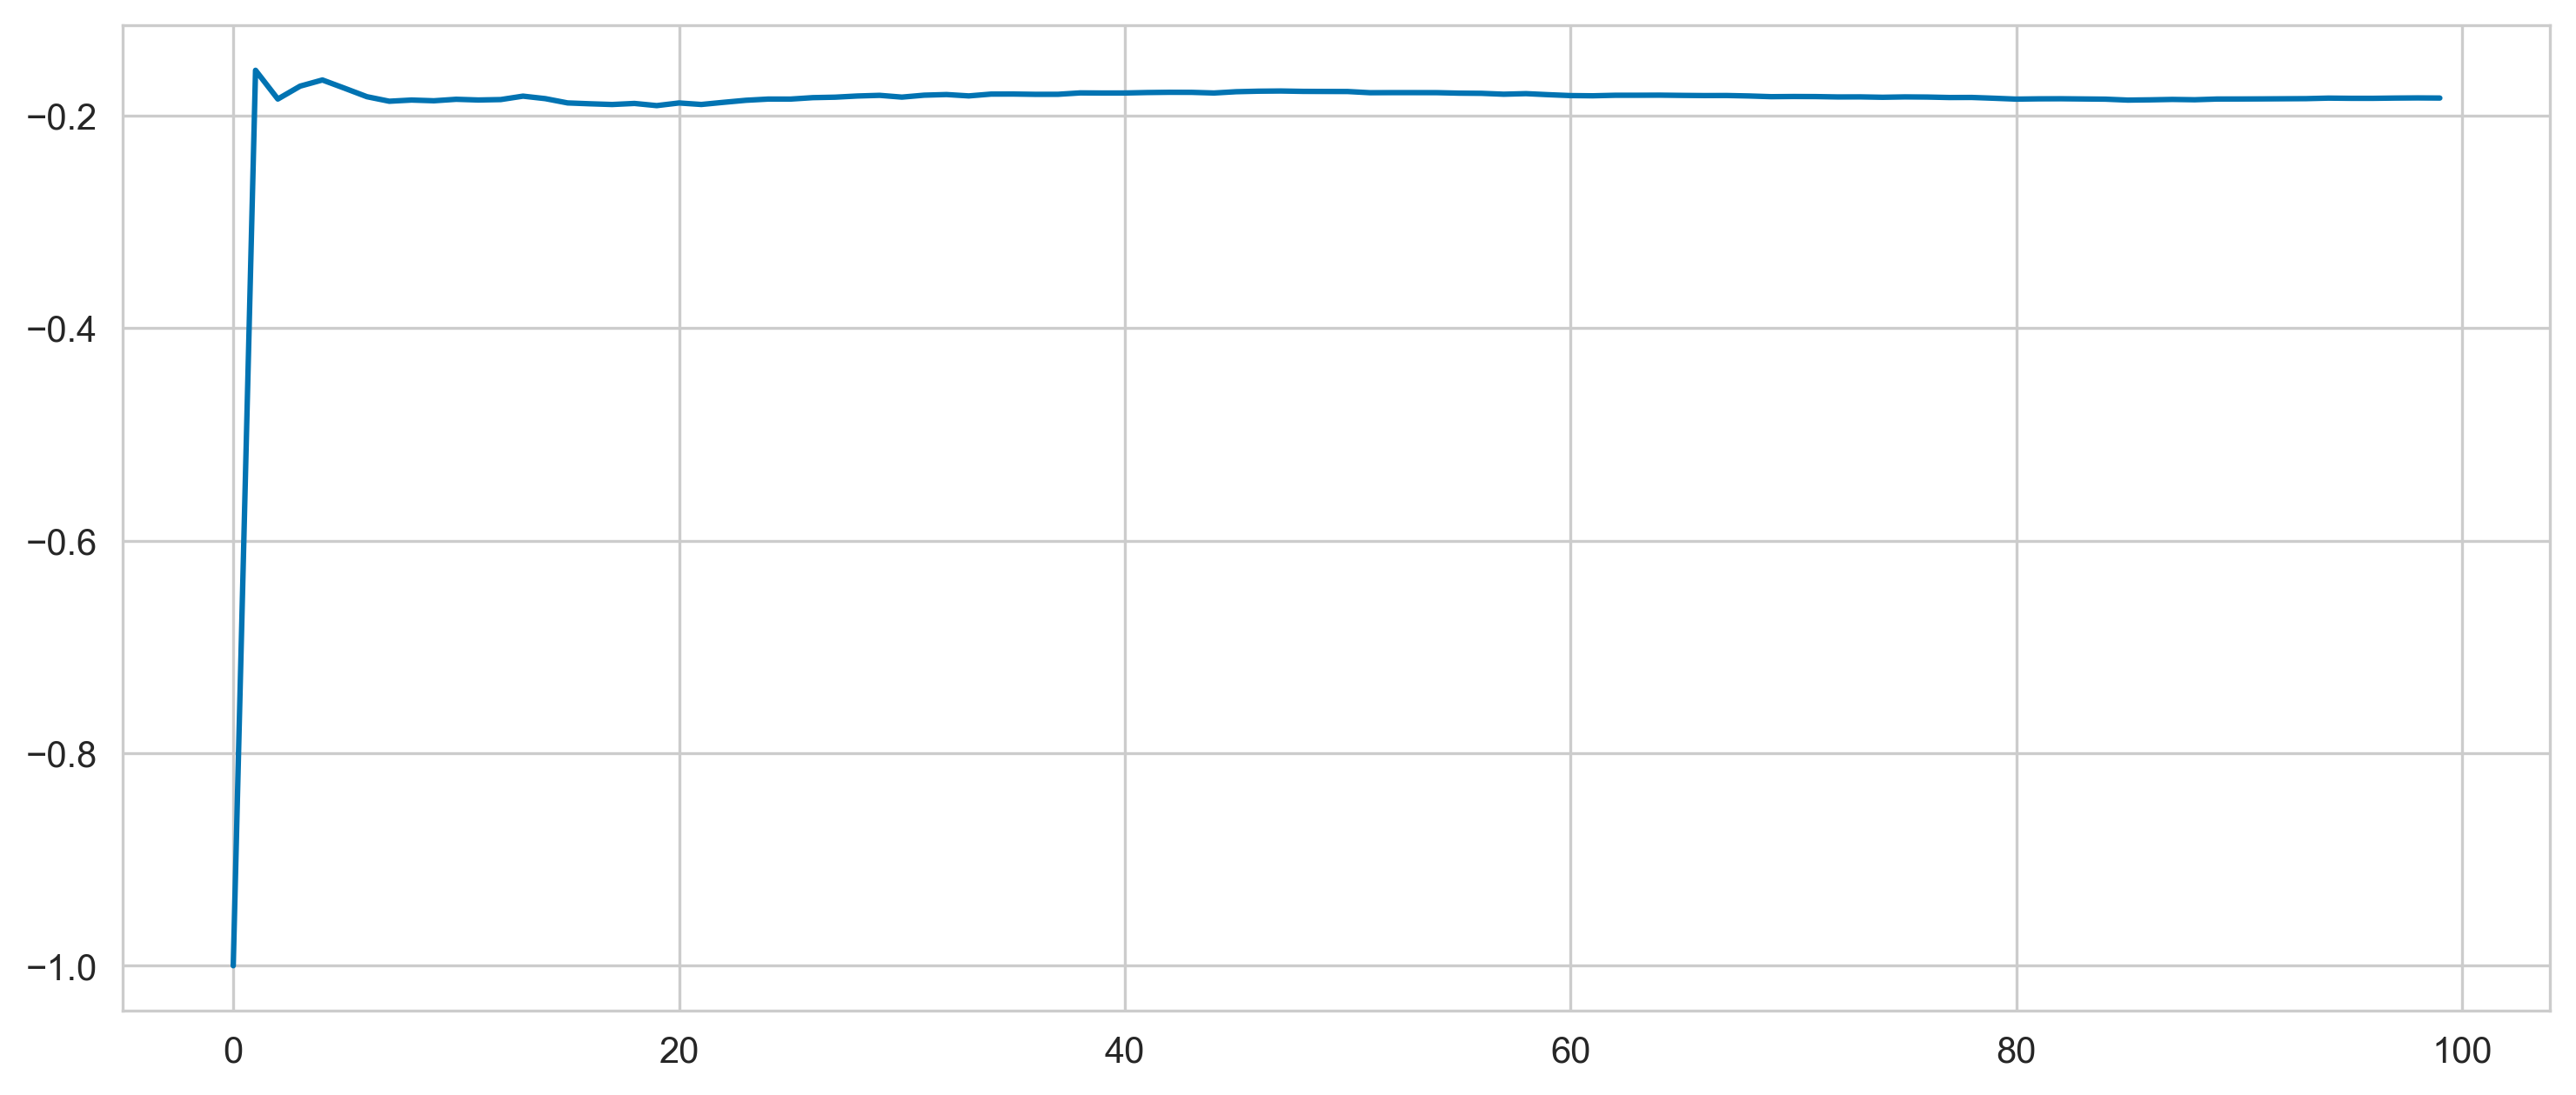

In [7]:
plt.figure(figsize=figsize)
plt.plot(range(len(deterministic_returns)), deterministic_returns)

$\textbf{Заключение:}$ при такой стратегии средний проигрыш казино составит около 20% от средней величины ставки

$\textbf{Часть 1. Вопрос 2.}$

2. Количество состояний определим как количество количество очков игрока, при которых добирать карты должна решать стратегия, т.е. если имея 11 очков, игрок в любом случае должен добирать, то при 12 очках уже должна решать стратегия, т.е.
это состояния от 12 до 21 (10 состояний), а также очки, отображаемые на раскрытой карте дилера - от 2 до 11 включительно, т.е. тоже 10 состояний. Кроме того, добавим также 10 терминальных состояний, по одному на каждое состояние дилера. Таким образом, будем иметь 110 состояний. 

Примечание: попытки ввести в рассмотрение usable ace результат не улучшили, поэтому рассматривается схема без их учета.

In [8]:
# Функции перевода очков игрока идилера в номер состояния. Матрица состояний вводится ниже.

def to_state_usable(player, dealer, usable):
    if usable:
        return states_matrix[state_of_p[player + 10], state_of_d[dealer]]
    else:
        return states_matrix[state_of_p[player], state_of_d[dealer]]
    
def to_state(player, dealer):
    return states_matrix[state_of_p[player], state_of_d[dealer]]

In [9]:
# Функция инициализации Q-function
def get_random_Q(nS, nA, final_states):
    Q = np.random.random(size=(nS, nA))
    Q[final_states, :] = 0
    return Q

# Функция взятия политики по Q-function
def compute_policy_by_Q(Q):
    return np.argmax(Q, axis=1)

# Функция прогона эпизода
def run_episode(env, pi, eps=0.0):
    
    (player_score, dealer_score, usable) = env.reset()
    states, actions, rewards = [], [], [0]
    game_over = env.done

    if game_over:
        states.append(to_state(player_score, dealer_score))
        #states.append(to_state(player_score, dealer_score, usable))
        actions.append(0)
        rewards.append(env.reward)
    
    while player_score < 12:
        (player_score, dealer_score, _), reward, game_over, _ = env.step(1)
    
    while not game_over:
        state = to_state(player_score, dealer_score)
        #state = to_state(player_score, dealer_score, usable)
        states.append(state)
        next_action = pi[state] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        (player_score, dealer_score, _), reward, game_over, _ = env.step(next_action)
        rewards.append(reward)
    
    states.append(to_state(22, dealer_score))
    #states.append(to_state(32, dealer_score, False))

    return states, actions, rewards

# Функция обновления матрицы накопленных наград как из лекции
def update_returns_actions(R, states, actions, rewards, gamma=1.0):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t
    g = 0
    if state_first_visit[states[-1]] == len(states)-1:
        R[states[-1]][actions[-1]].append(g)

    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:
            R[states[t]][actions[t - 1]].append(g)
            
    return R

# Функция обновления матрицы средних наград, которая используется далее
def update_returns_fast(R, states, actions, rewards, gamma=1.0):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state] == -1:
            state_first_visit[state] = t

    g = 0
    if state_first_visit[states[-1]] == len(states) - 1:
        R[states[-1]][actions[-1]][0] += g
        R[states[-1]][actions[-1]][1] += 1

    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[states[t]] == t:            
            R[states[t]][actions[t]][0] += g
            R[states[t]][actions[t]][1] += 1
            
    return R

# Функция взятия Q-function по матрице средних наград
def get_Q_by_R(R, Q):
    for s in range(nS):
        for a in range(nA):
            if R[s][a][1] > 0:
                Q[s, a] = R[s][a][0] / R[s][a][1]
    return Q

# Функция подсчета средних выигрышей (используется для оценки финальной политики)
def get_mean_return(env, pi, min_score=12, iterations=100000):
    rewards = [0]

    for n in range(1, iterations):
        (player_score, dealer_score, _) = env.reset()
        game_over = env.done

        if game_over:
            reward = env.reward

        while player_score < min_score:
            (player_score, dealer_score, _), reward, game_over, _ = env.step(1)

        while not game_over:
            state = states_matrix[state_of_p[player_score], state_of_d[dealer_score]]
            next_action = pi[state]
            (player_score, dealer_score, _), reward, game_over, _ = env.step(next_action)
        
        rewards.append(reward)
        
    mean_returns = []
    bucket = len(rewards) // 100

    for i in range(100):
        mean_returns.append(sum(rewards[:(i + 1) * bucket]) / ((i + 1) * bucket))

    return mean_returns

# Функция для отображения матрицы состояний в виде Pandas-dataframe для наглядности
def states_frame(data):
    index = ["player's score: " + str(score) for score in state_of_p.keys()]
    columns = ["dealer's score: " + str(score) for score in state_of_d.keys()]
    data_matrix = data.reshape((len(state_of_p), len(state_of_d)))
    frame = pd.DataFrame(data_matrix, index=index, columns=columns)
    
    return frame

In [10]:
#state_of_p = {score: state for state, score in enumerate(range(12, 33))}
state_of_p = {score: state for state, score in enumerate(range(12, 23))}# player states dict
state_of_d = {score: state for state, score in enumerate(range(1, 11))} # dealer states dict
nS = len(state_of_p) * len(state_of_d)
states_matrix = np.arange(nS).reshape((len(state_of_p), len(state_of_d))) # matrix mapping [player_state, dealer_state]
                                                                          # to number
# Demonstrate player's and dealer's joint scores into ordinal mapping:    
states_frame(states_matrix.flatten())

# МАТРИЦА СОСТОЯНИЙ:

,dealer's score: 1,dealer's score: 2,dealer's score: 3,dealer's score: 4,dealer's score: 5,dealer's score: 6,dealer's score: 7,dealer's score: 8,dealer's score: 9,dealer's score: 10
player's score: 12,0,1,2,3,4,5,6,7,8,9
player's score: 13,10,11,12,13,14,15,16,17,18,19
player's score: 14,20,21,22,23,24,25,26,27,28,29
player's score: 15,30,31,32,33,34,35,36,37,38,39
player's score: 16,40,41,42,43,44,45,46,47,48,49
player's score: 17,50,51,52,53,54,55,56,57,58,59
player's score: 18,60,61,62,63,64,65,66,67,68,69
player's score: 19,70,71,72,73,74,75,76,77,78,79
player's score: 20,80,81,82,83,84,85,86,87,88,89
player's score: 21,90,91,92,93,94,95,96,97,98,99


$\textbf{А) Решение методом Монте-Карло on-policy:}$

In [11]:
env = BlackjackEnv()

init_episodes, total_episodes = 100, 100000
nA = 2
gamma = 1.
# Q = np.zeros((nS, nA))

terminate_states = states_matrix[-1, :]
Q = get_random_Q(nS, nA, terminate_states)
pi = compute_policy_by_Q(Q)
rewards_all = []

R = [ [ [0, 0] for _ in range(nA) ] for _ in range(nS) ]

for _ in range(init_episodes):
    states, actions, rewards = run_episode(env, pi, eps=0.1)
    R = update_returns_fast(R, states, actions, rewards, gamma=gamma)

for _ in range(total_episodes):
    states, actions, rewards = run_episode(env, pi, eps=0.1)
    R = update_returns_fast(R, states, actions, rewards, gamma=gamma)
    Q = get_Q_by_R(R, Q)    
    pi = compute_policy_by_Q(Q)
    rewards_all.append(rewards[-1])
    
env.close()

In [12]:
states_frame(pi)

,dealer's score: 1,dealer's score: 2,dealer's score: 3,dealer's score: 4,dealer's score: 5,dealer's score: 6,dealer's score: 7,dealer's score: 8,dealer's score: 9,dealer's score: 10
player's score: 12,1,0,0,1,1,0,1,1,1,1
player's score: 13,1,0,1,0,0,0,1,0,1,1
player's score: 14,1,0,0,0,0,0,1,1,0,1
player's score: 15,1,1,0,1,0,0,1,1,1,1
player's score: 16,1,0,0,0,0,0,0,0,0,1
player's score: 17,0,0,0,0,0,0,0,0,0,0
player's score: 18,0,0,0,0,0,0,0,0,0,0
player's score: 19,0,0,0,0,0,0,0,0,0,0
player's score: 20,0,0,0,0,0,0,0,0,0,0
player's score: 21,0,0,0,0,0,0,0,0,0,0


In [13]:
# Сравним на графике средние выигрыши от детерминированной стратегии (Stand at 19-21),
# случайной стратегии и нашей финальной стратегий
# Случайная стратегия: 
random_pi = np.random.randint(0, 2, 110)

env = BlackjackEnv()
mean_reward = 0
new_reward = 0
random_means = []

for n in range(100000):
    new_reward = episode_reward(env, random_pi)
    mean_reward = mean_reward + (new_reward - mean_reward) / (n + 1)
    if n % 1000 == 0:
        random_means.append(mean_reward)

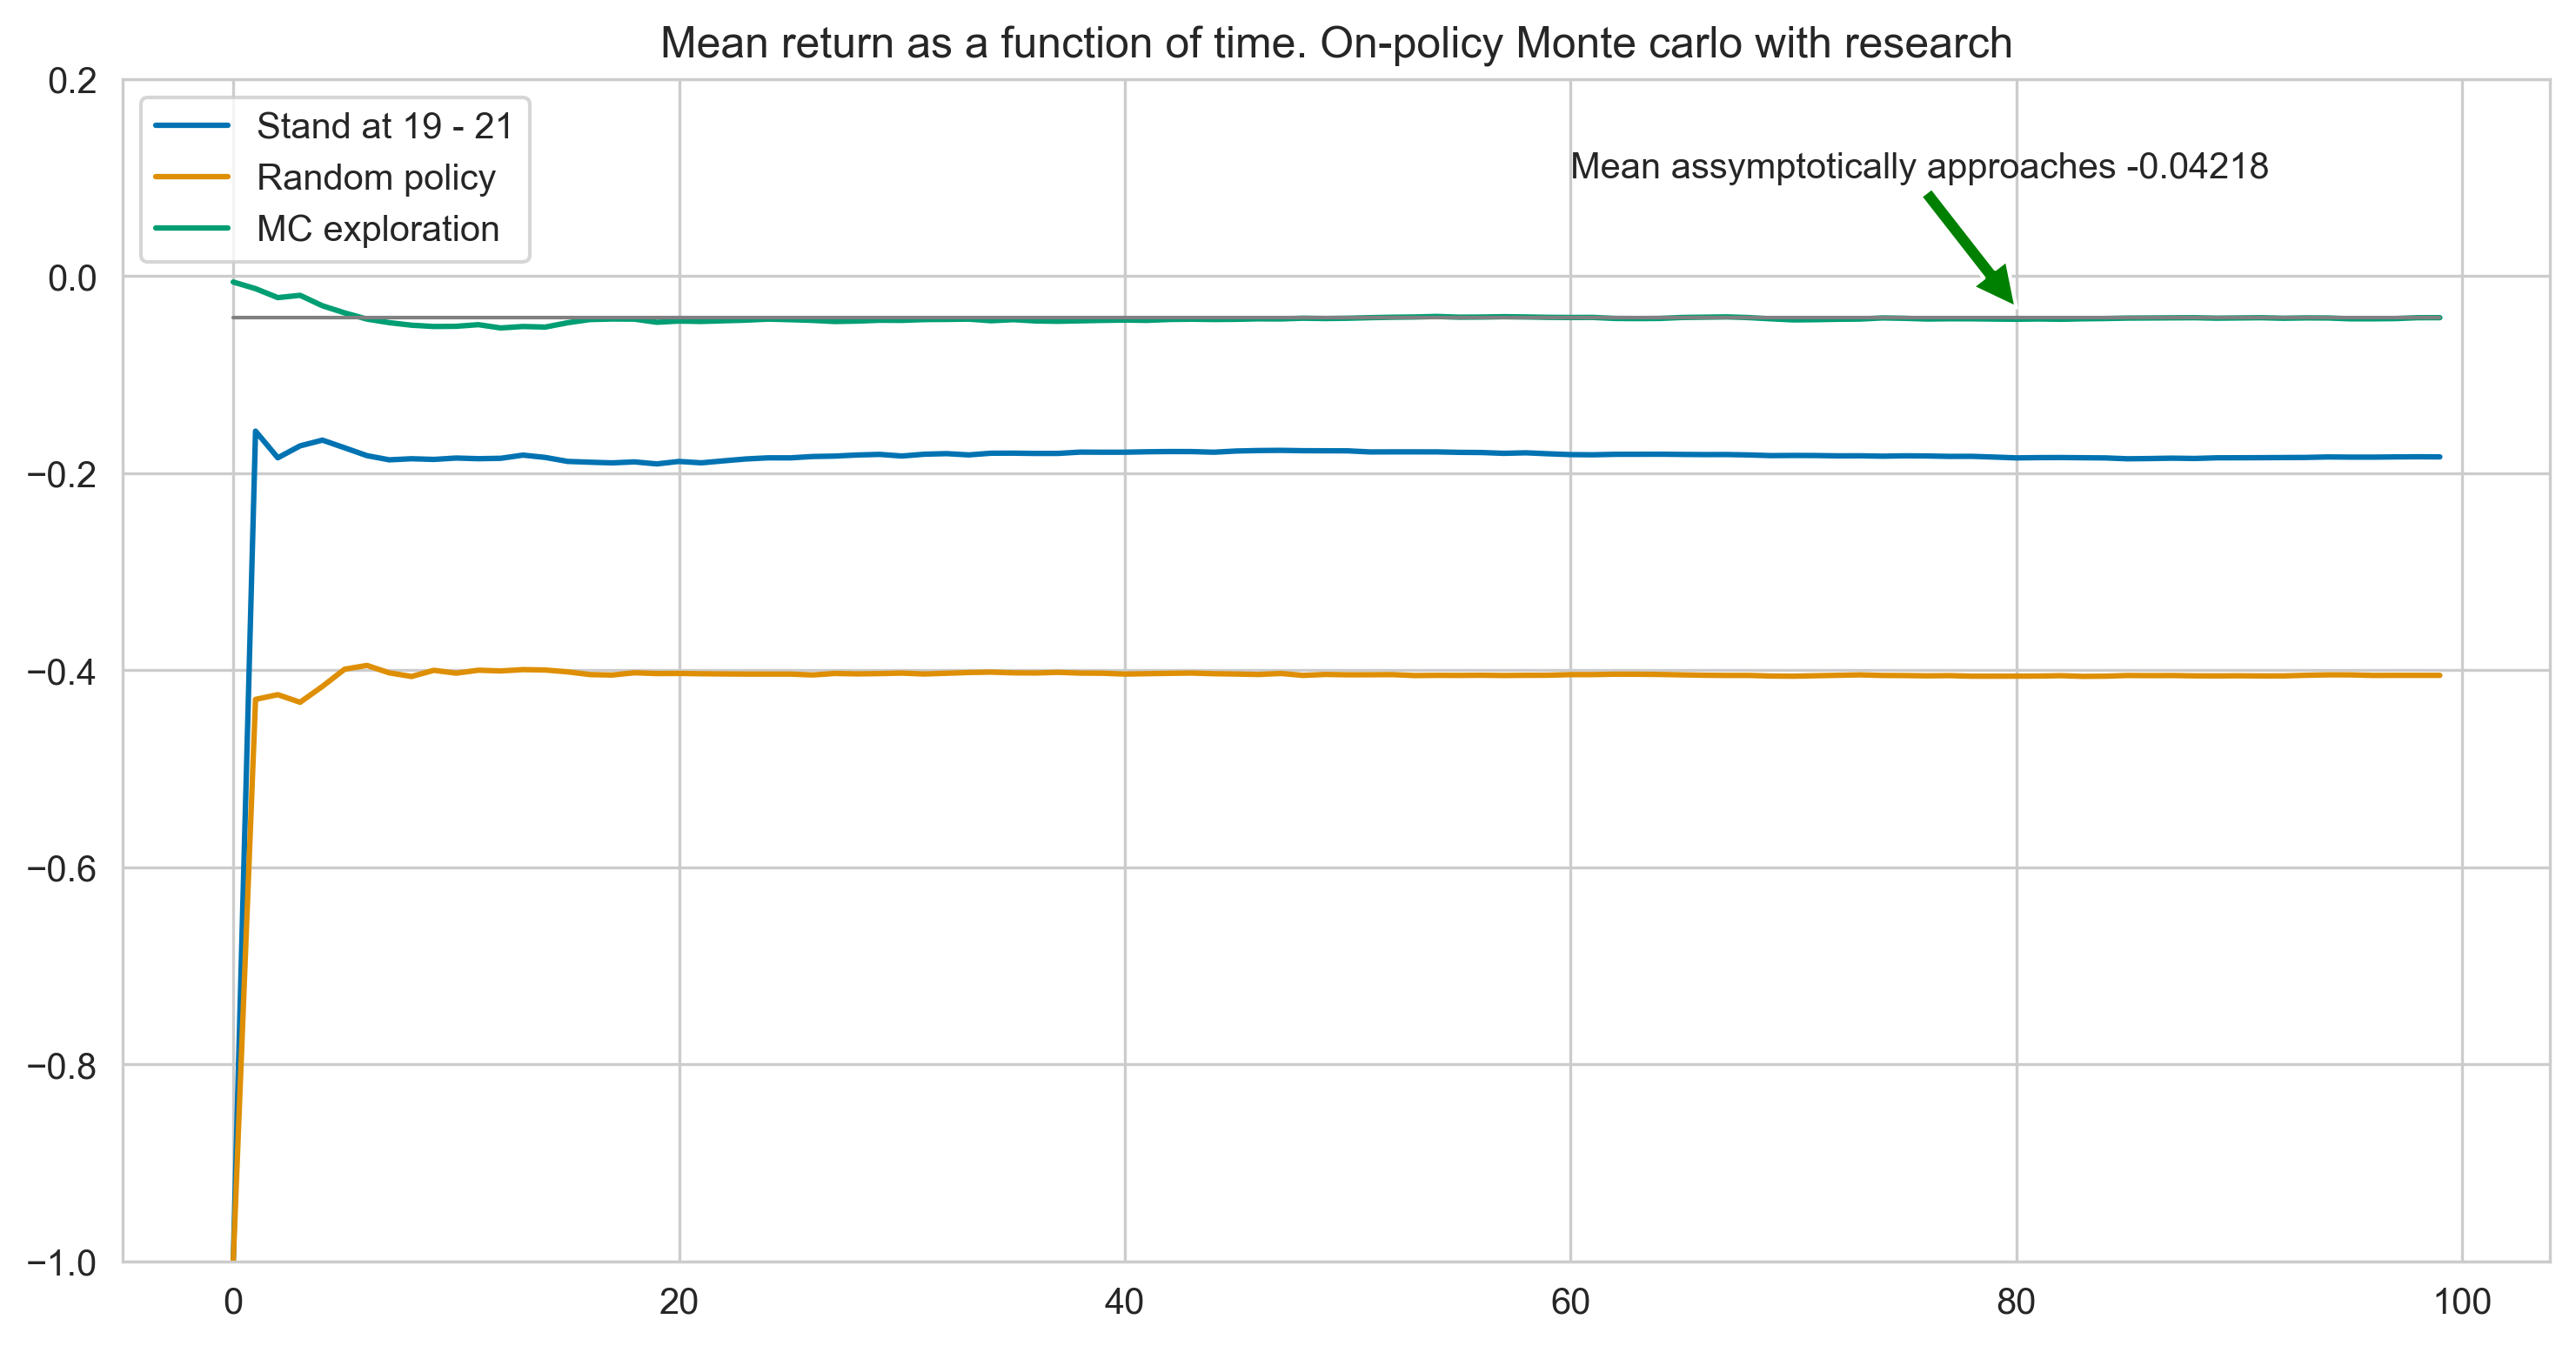

In [15]:
mean_returns = get_mean_return(env, pi, min_score=12)
    
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='MC exploration')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.title('Mean return as a function of time. On-policy Monte carlo with research')
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, mean_returns[-1] + 0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

$\textbf{Б) Решение методом Q-learning:}$

In [17]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=1.0):
    
    (player, dealer, _) = env.reset()
    game_over = env.done

    if game_over:
        reward = env.reward
        s = to_state(player, dealer)#states_matrix[state_of_p[player], state_of_d[dealer]]
        s_prime = to_state(22, dealer)#states_matrix[state_of_p[22], state_of_d[dealer]]
        Q[s][0] = Q[s][0] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][0])
        return
    
    while player < 12:
        (player, dealer, _), reward, game_over, _ = env.step(1)
    
    s = to_state(player, dealer)#states_matrix[state_of_p[player], state_of_d[dealer]]
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

    while not game_over:
        (player, dealer, _), reward, game_over, _ = env.step(a)
        player = min(22, player)
        s_prime = to_state(player, dealer)#states_matrix[state_of_p[player], state_of_d[dealer]]
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
    
    return

def sarsa_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    
    (player, dealer, _) = env.reset()
    game_over = env.done

    if game_over:
        reward = env.reward
        s = states_matrix[state_of_p[player], state_of_d[dealer]]
        s_prime = states_matrix[state_of_p[22], state_of_d[dealer]]
        Q[s][0] = Q[s][0] + alpha * (reward + gamma * Q[s_prime, pi[s_prime]] - Q[s][0])
        return Q
    
    while player < 12:
        (player, dealer, _), reward, game_over, _ = env.step(1)
    
    s = states_matrix[state_of_p[player], state_of_d[dealer]]
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

    while not game_over:
        (player, dealer, _), reward, game_over, _ = env.step(a)
        player = min(22, player)
        s_prime = states_matrix[state_of_p[player], state_of_d[dealer]]
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * Q[s_prime, pi[s_prime]] - Q[s][a])
        s, a = s_prime, a_prime
    
    return Q

In [18]:
state_of_p = {score: state for state, score in enumerate(range(12, 23))} # player states dict
state_of_d = {score: state for state, score in enumerate(range(1, 11))} # dealer states dict
nS = len(state_of_p) * len(state_of_d)
nA = 2
states_matrix = np.arange(nS).reshape((len(state_of_p), len(state_of_d)))

env = BlackjackEnv()
total_episodes = 150000

Q = np.zeros((nS, nA))
pi = compute_policy_by_Q(Q)

for n in range(total_episodes):
    Q_learning_episode(env, pi, Q, alpha=0.001, epsilon=0.1, gamma=1.0)
    #Q = sarsa_episode(env, pi, Q, alpha=0.1, epsilon=0.05, gamma=1.)
    pi = compute_policy_by_Q(Q)
    
env.close()

In [19]:
states_frame(pi)

,dealer's score: 1,dealer's score: 2,dealer's score: 3,dealer's score: 4,dealer's score: 5,dealer's score: 6,dealer's score: 7,dealer's score: 8,dealer's score: 9,dealer's score: 10
player's score: 12,1,1,0,1,1,1,1,1,1,1
player's score: 13,1,1,1,0,1,1,1,1,1,1
player's score: 14,0,1,1,1,1,1,1,1,1,1
player's score: 15,1,1,1,0,0,1,1,1,1,1
player's score: 16,1,0,0,0,0,0,1,1,0,1
player's score: 17,1,1,0,0,0,0,1,1,1,1
player's score: 18,1,0,0,0,0,0,0,0,0,1
player's score: 19,0,0,0,0,0,0,0,0,0,0
player's score: 20,0,0,0,0,0,0,0,0,0,0
player's score: 21,0,0,0,0,0,0,0,0,0,0


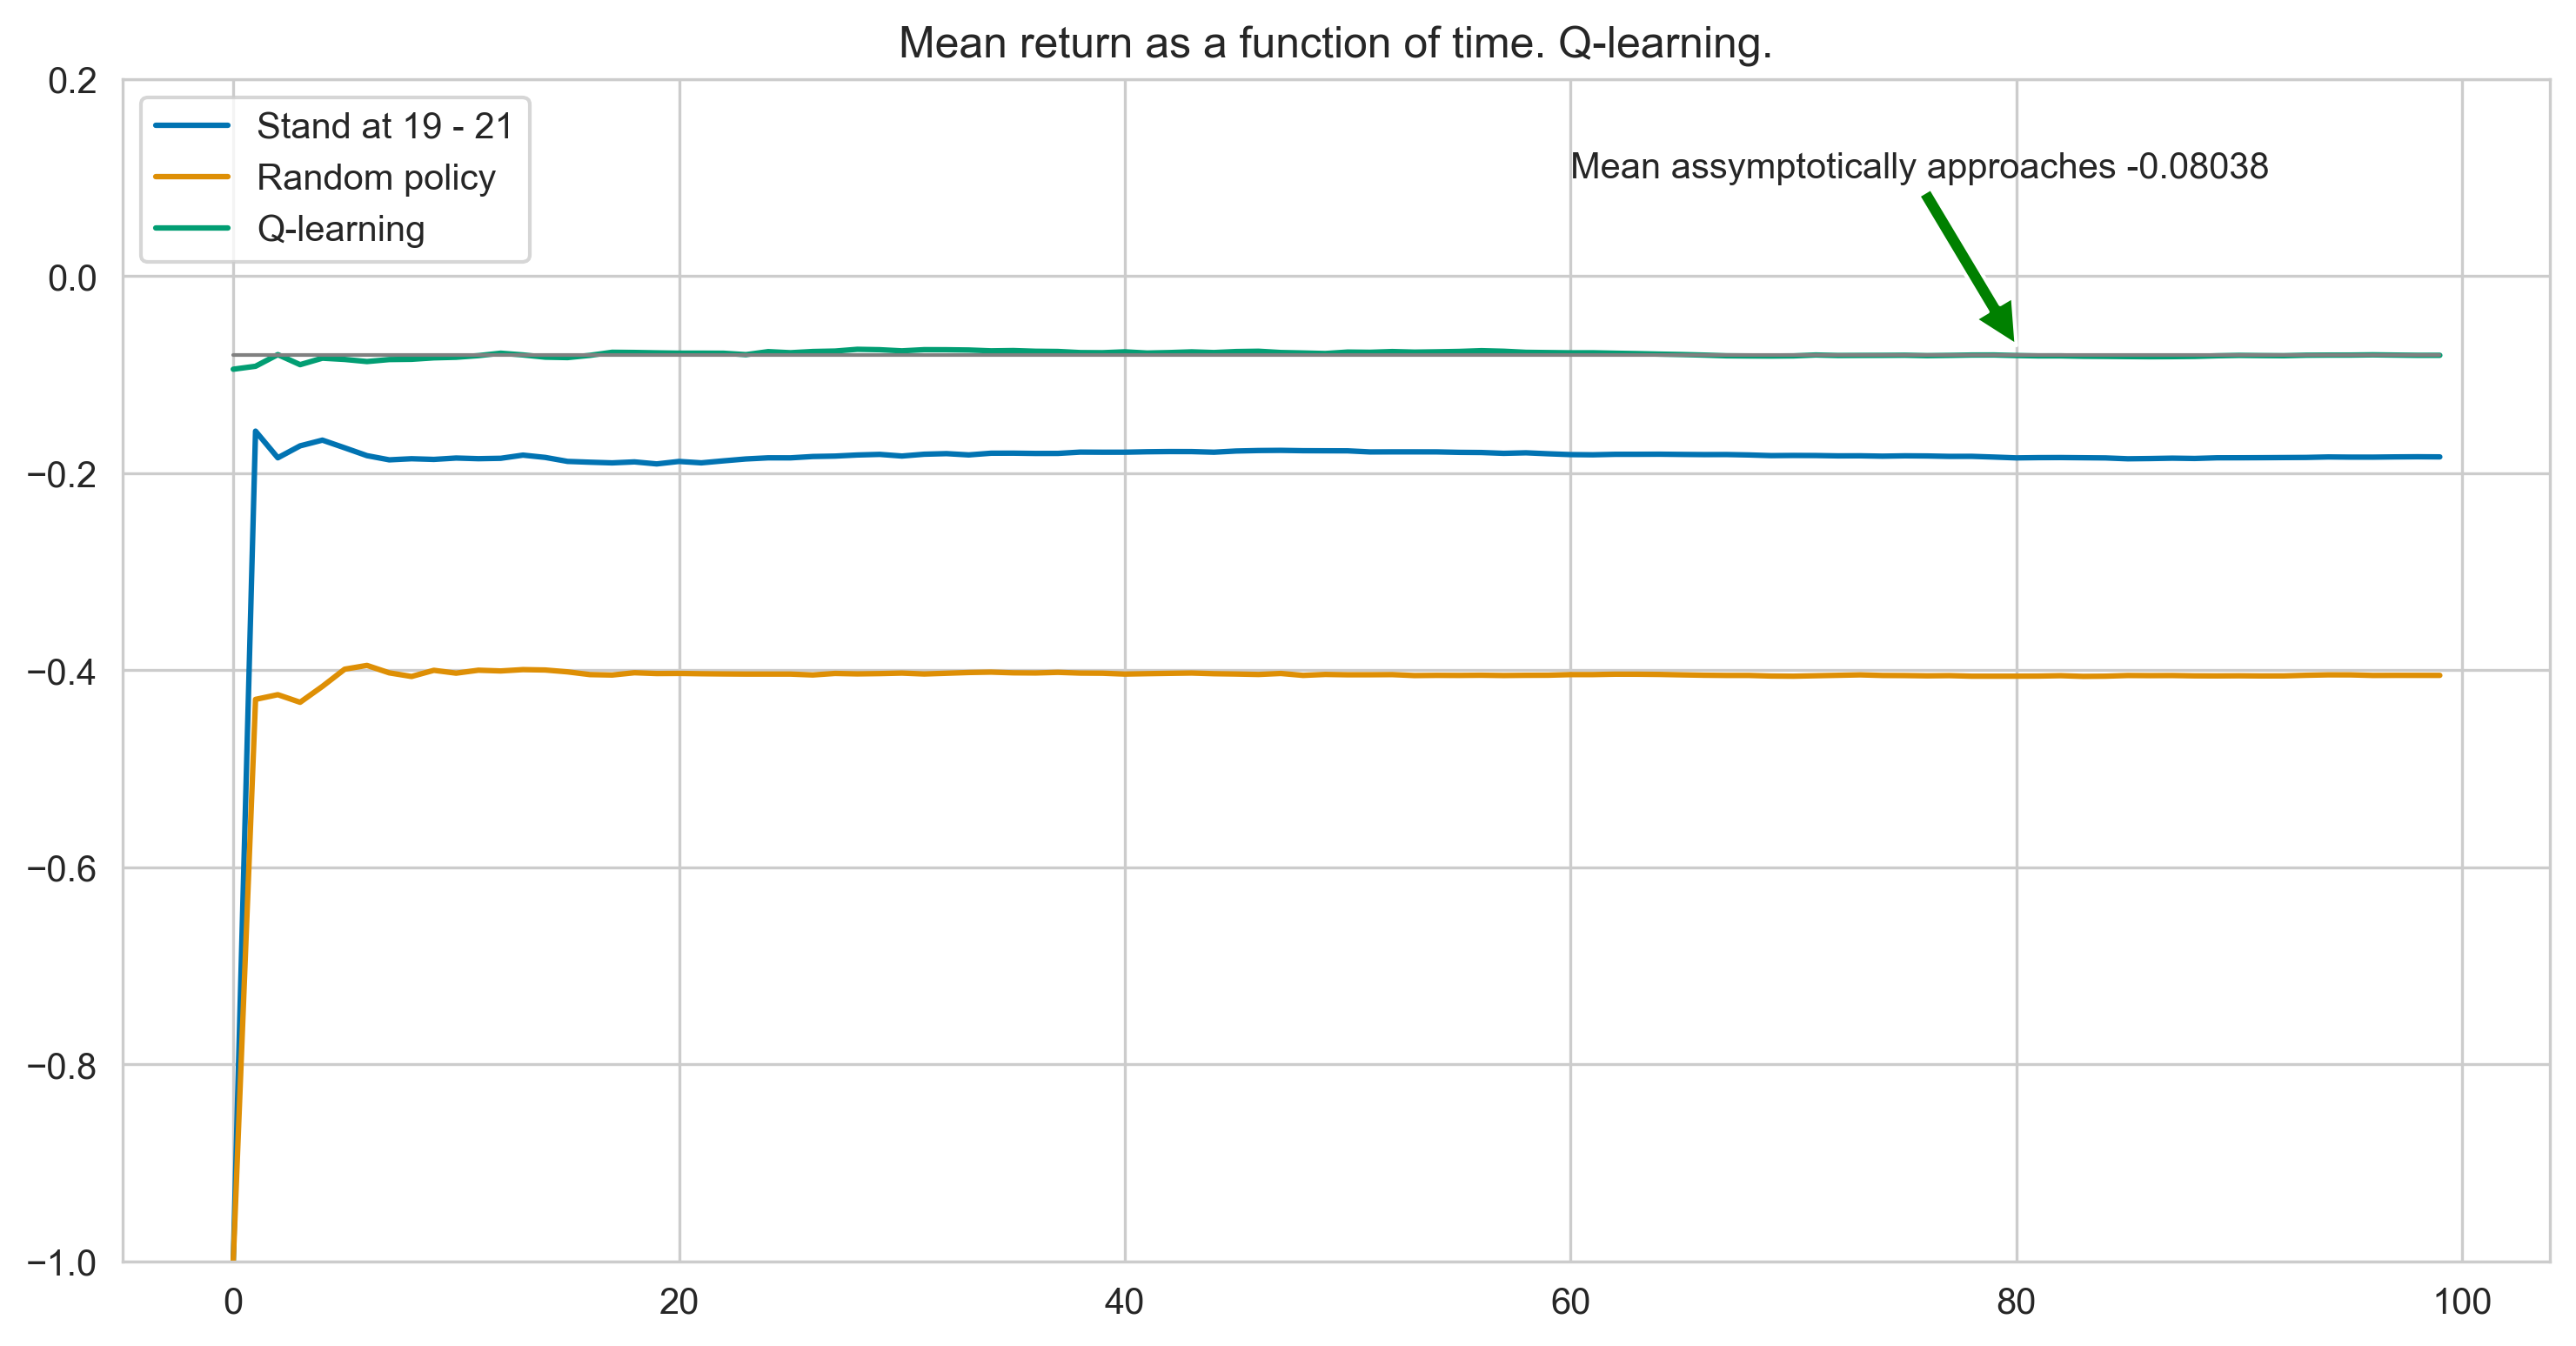

In [21]:
mean_returns = get_mean_return(env, pi, min_score=12)
    
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='Q-learning')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.title('Mean return as a function of time. Q-learning.')
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, mean_returns[-1] + 0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

Заключение: Q-learning работает очень быстро, но для него довольно трудно подбирать гипермараметры. В итоге, лучшее из того, что удаолсь получить оказалось примерно в два раза хуже результата, полученного методом Монте-Карло. Возможно, для Q-learning имеет смысл использовать уменьшающуся скорость обучения, но мне такую подобрать не удалось.

$\textbf{Часть 2.}$

1. Созданим новый класс BlackjackDoubleEnv и отнаследуем его от BlackjackEnv, переопределив функцию step, добавив в нее дополнительное действие, при котором игроку выдается одна карта из колоды (по условию), после чего игрок переходит в позицию Stand, и игра заканчивается дилером.

In [22]:
class BlackjackDoubleEnv(BlackjackEnv):
    def __init__(self):
        super().__init__()
        self.double = 1
        
    def step(self, action):
        #assert self.action_space.contains(action)
        
        # Double action:
        if action == 2:
            self.double = 2
            self.step(1) # Pick up an extra card
            self.step(0) # and then stick / stand
        
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                self.done = True
                self.reward = -1.0
            else:
                self.done = False
                self.reward = 0.0
            
        elif action == 0:  # stick: play out the dealers hand, and score
            self.done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            self.reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                self.reward = 1.0
            elif (
                not self.sab
                and is_natural(self.player)
                and self.reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                self.reward = 1.5
        return self._get_obs(), self.reward * self.double, self.done, {}
    
    def reset(self):
        self.double = 1
        self.reward = -1.0
        self.done = False
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        if is_natural(self.player):
            self.step(0)
        return self._get_obs()

$\textbf{А) Решение методом Монте-Карло on-policy:}$

In [23]:
# Функция прогона эпизода с двойными ставками

def run_double_episode(env, pi, eps=0.0):
    
    (player_score, dealer_score, usable) = env.reset()
    states, actions, rewards = [], [], [0]
    game_over = env.done

    if game_over:
        states.append(to_state(player_score, dealer_score))
        actions.append(0)
        rewards.append(env.reward)
    
    while not game_over:
        state = to_state(player_score, dealer_score)
        states.append(state)
        next_action = pi[state] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        (player_score, dealer_score, _), reward, game_over, _ = env.step(next_action)
        rewards.append(reward)
    
    states.append(to_state(22, dealer_score))

    return states, actions, rewards

In [24]:
state_of_p = {score: state for state, score in enumerate(range(4, 23))} # player states dict
state_of_d = {score: score - 1 for score in range(1, 11)} # dealer states dict
nS = len(state_of_p) * len(state_of_d)
nA = 3 # Размерность пространства действий увеличивается до 3-х
states_matrix = np.arange(nS).reshape((len(state_of_p), len(state_of_d)))

env = BlackjackDoubleEnv()

init_episodes, total_episodes = 100, 150000
gamma = 1.

terminate_states = states_matrix[-1, :]
Q = get_random_Q(nS, nA, terminate_states)
pi = compute_policy_by_Q(Q)

R = [ [ [0, 0] for _ in range(nA) ] for _ in range(nS) ]

for _ in range(init_episodes):
    states, actions, rewards = run_double_episode(env, pi, eps=0.2)
    R = update_returns_fast(R, states, actions, rewards, gamma=gamma)

for _ in range(total_episodes):
    states, actions, rewards = run_double_episode(env, pi, eps=0.2)
    R = update_returns_fast(R, states, actions, rewards, gamma=gamma)
    Q = get_Q_by_R(R, Q)    
    pi = compute_policy_by_Q(Q)

In [25]:
states_frame(pi)

,dealer's score: 1,dealer's score: 2,dealer's score: 3,dealer's score: 4,dealer's score: 5,dealer's score: 6,dealer's score: 7,dealer's score: 8,dealer's score: 9,dealer's score: 10
player's score: 4,0,0,2,0,0,0,0,1,0,1
player's score: 5,0,0,1,1,0,1,1,0,1,1
player's score: 6,1,0,0,1,1,0,0,0,1,1
player's score: 7,1,0,1,2,1,0,0,1,1,1
player's score: 8,1,1,1,2,2,1,1,1,0,1
player's score: 9,1,2,1,2,2,2,1,1,1,1
player's score: 10,1,2,2,2,2,2,2,2,2,2
player's score: 11,2,2,2,1,2,2,2,2,2,2
player's score: 12,1,2,0,2,0,0,1,1,1,1
player's score: 13,1,0,0,0,0,0,2,1,1,1


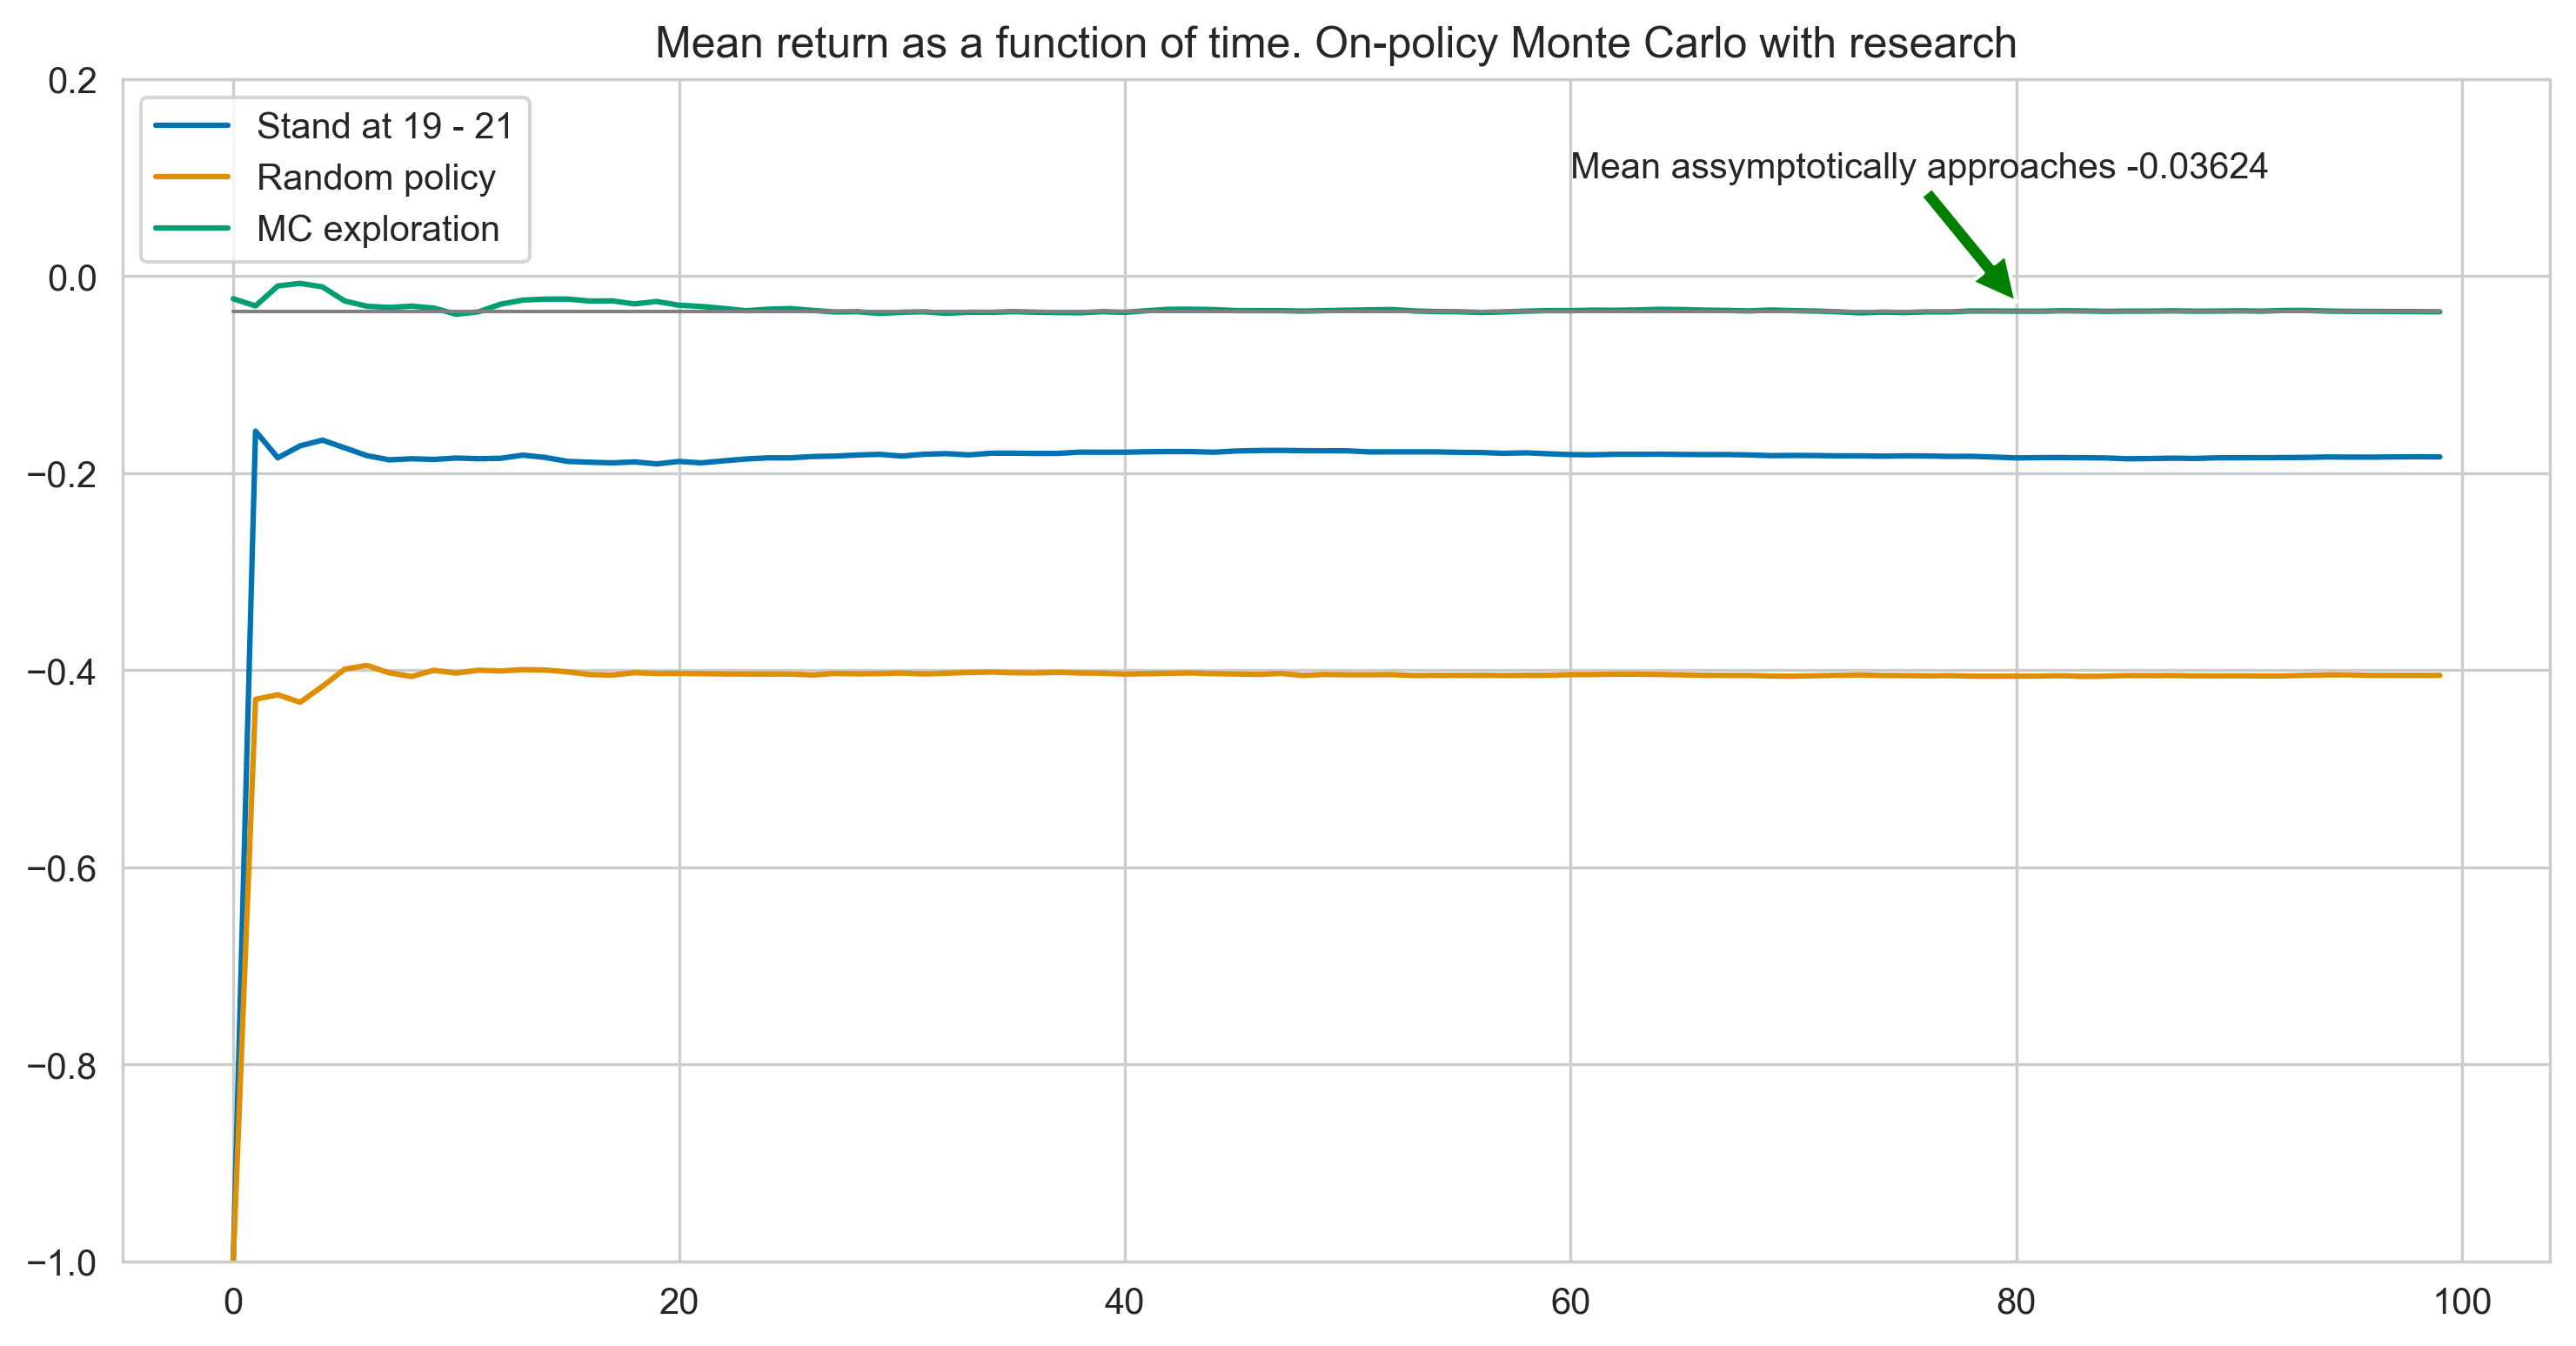

In [26]:
mean_returns = get_mean_return(env, pi, min_score=4)
    
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='MC exploration')
plt.title('Mean return as a function of time. On-policy Monte Carlo with research')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, mean_returns[-1] + 0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

$\textbf{Б) Решение методом Q-learning:}$

In [27]:
def Q_learning_double_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=1.0):
    
    (player, dealer, _) = env.reset()
    game_over = env.done

    if game_over:
        reward = env.reward
        s = to_state(player, dealer)
        s_prime = to_state(22, dealer)
        Q[s][0] = Q[s][0] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][0])
        return
    
    s = to_state(player, dealer)
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

    while not game_over:
        (player, dealer, _), reward, game_over, _ = env.step(a)
        player = min(22, player)
        s_prime = to_state(player, dealer)
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
    
    return

In [31]:
state_of_p = {score: state for state, score in enumerate(range(4, 23))} # player states dict
state_of_d = {score: state for state, score in enumerate(range(1, 11))} # dealer states dict
nS = len(state_of_p) * len(state_of_d)
nA = 3
states_matrix = np.arange(nS).reshape((len(state_of_p), len(state_of_d)))
terminate_states = states_matrix[-1, :]

env = BlackjackDoubleEnv()
total_episodes = 150000
gamma = 1.

#Q = get_random_Q(nS, nA, terminate_states)
Q = np.zeros((nS, nA))
pi = compute_policy_by_Q(Q)

for n in range(total_episodes):
    Q_learning_double_episode(env, pi, Q, alpha=0.001, epsilon= 0.2, gamma=1.)
    pi = compute_policy_by_Q(Q)
    
env.close()

In [32]:
states_frame(pi)

,dealer's score: 1,dealer's score: 2,dealer's score: 3,dealer's score: 4,dealer's score: 5,dealer's score: 6,dealer's score: 7,dealer's score: 8,dealer's score: 9,dealer's score: 10
player's score: 4,1,1,1,1,1,1,1,1,1,1
player's score: 5,1,1,1,1,1,0,1,1,1,1
player's score: 6,1,2,1,1,1,1,1,1,1,1
player's score: 7,1,1,1,1,1,1,1,1,1,1
player's score: 8,1,1,1,1,1,1,1,1,0,1
player's score: 9,1,1,2,1,1,1,1,1,1,1
player's score: 10,1,1,1,1,2,1,1,2,1,1
player's score: 11,1,2,2,1,2,2,2,2,1,1
player's score: 12,1,1,2,2,0,2,2,1,1,1
player's score: 13,1,2,1,1,2,2,1,1,2,1


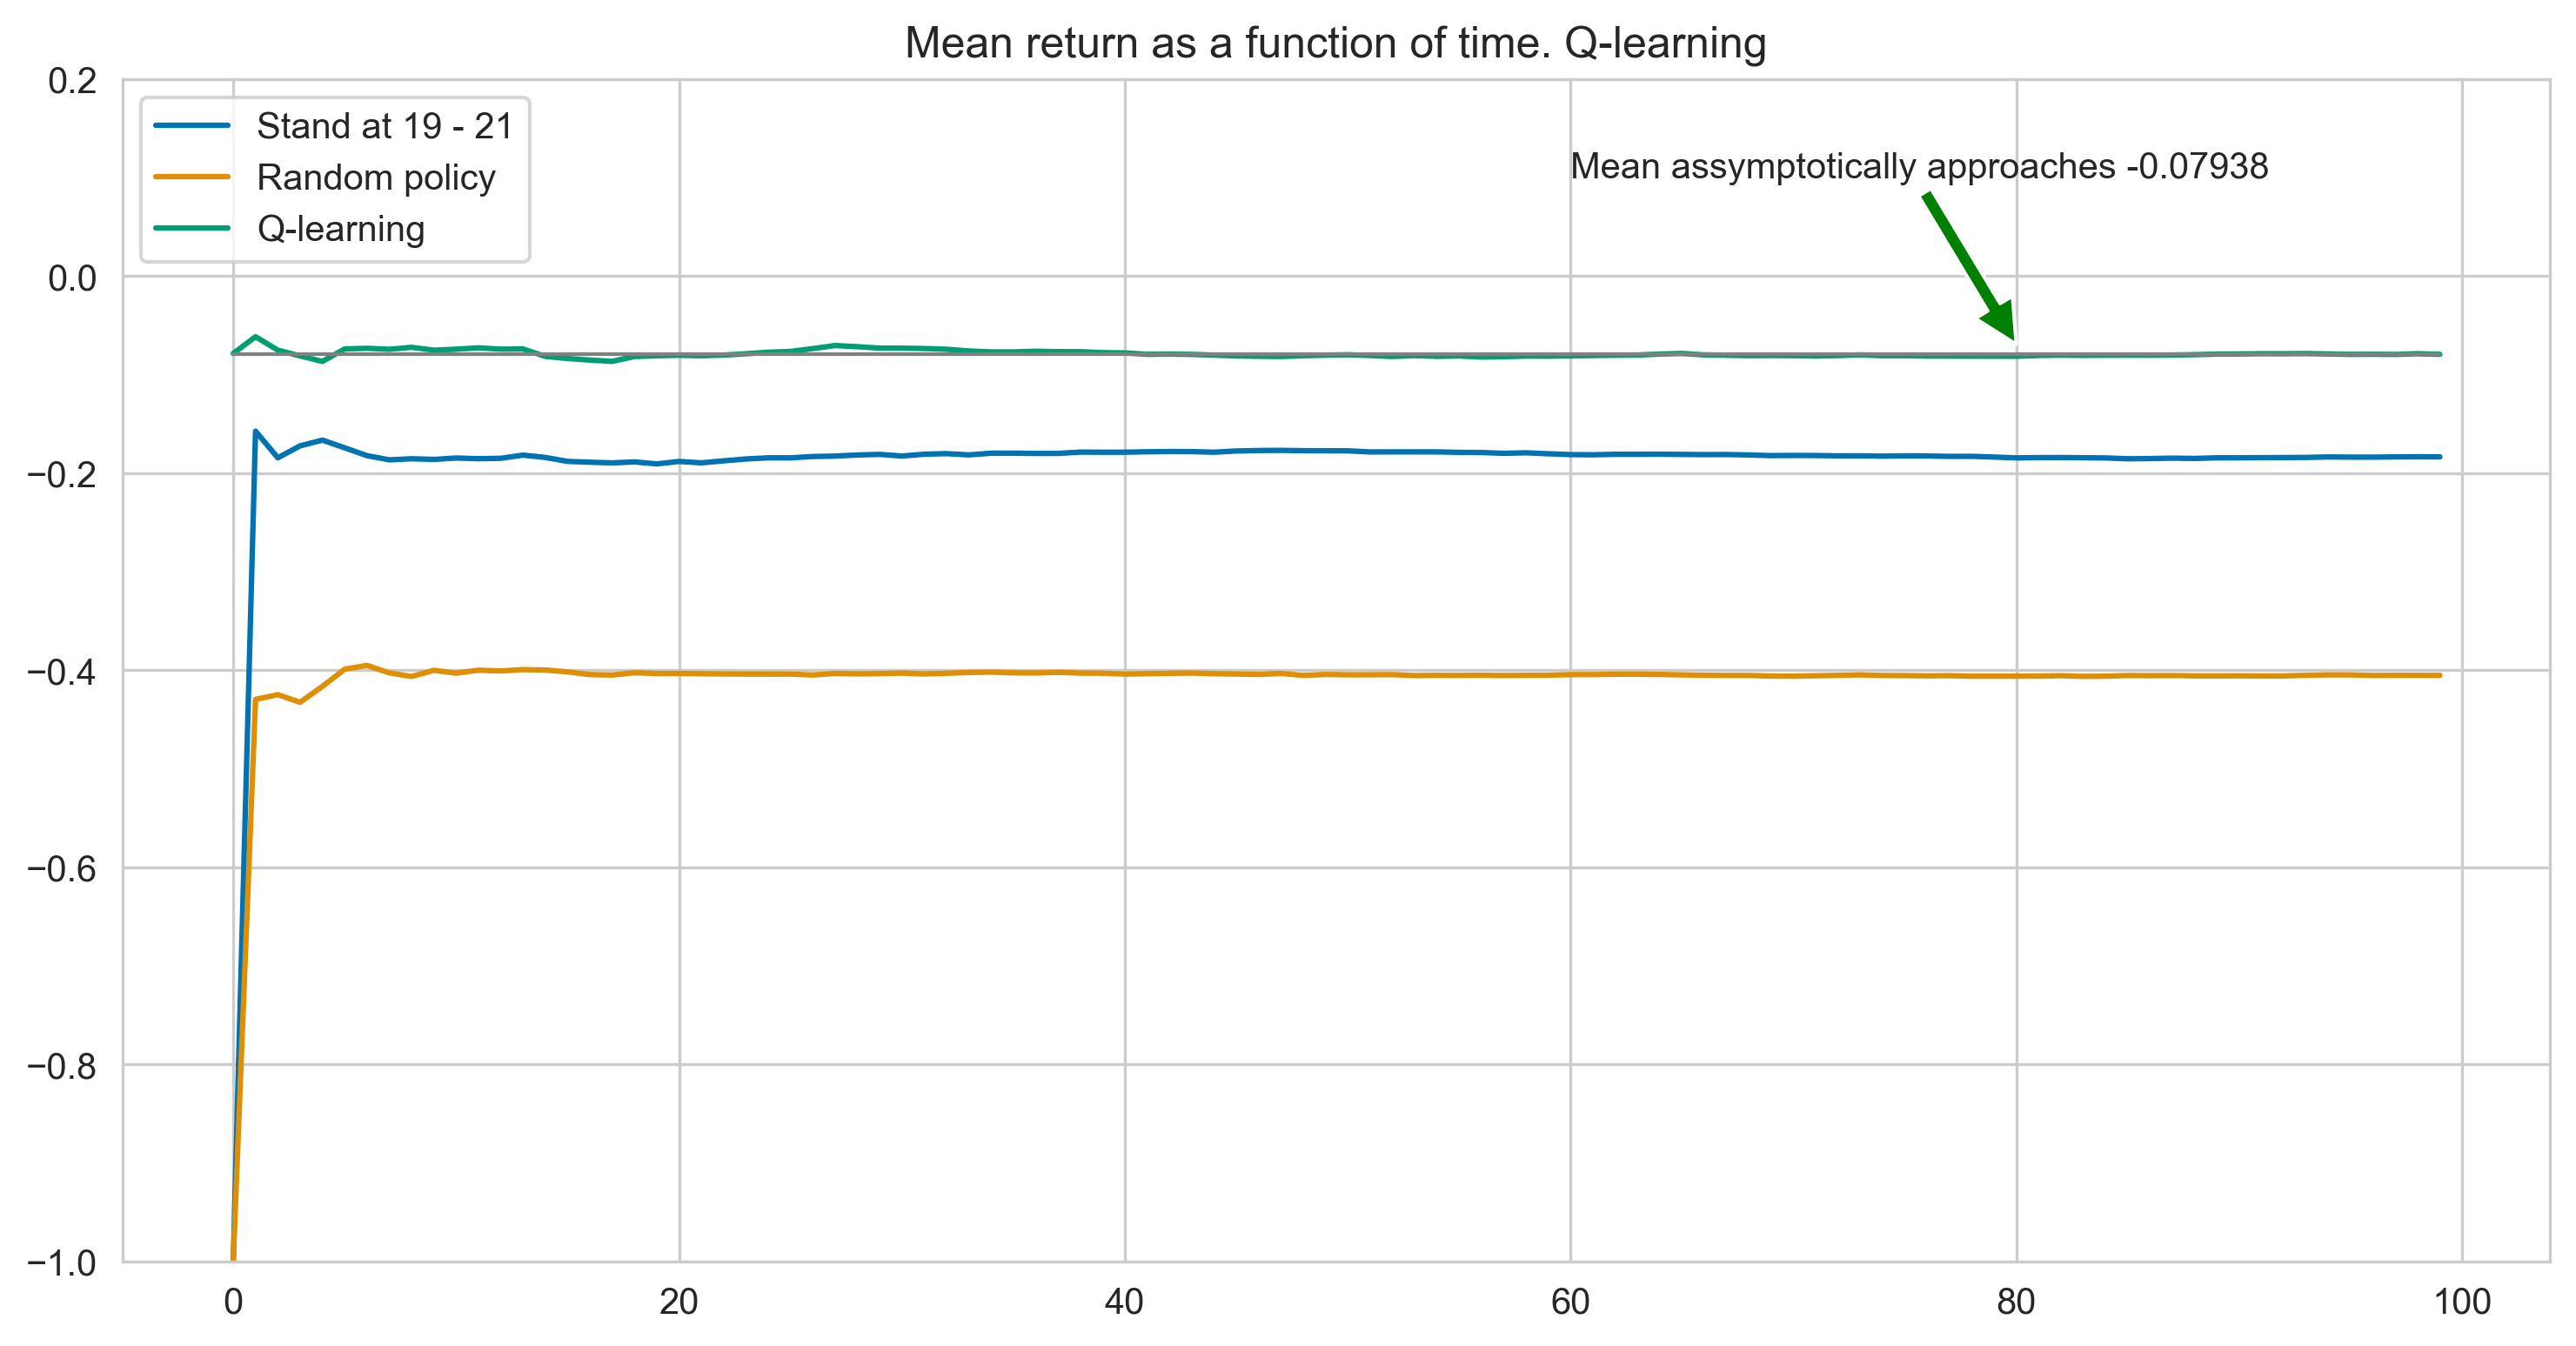

In [33]:
mean_returns = get_mean_return(env, pi)
    
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='Q-learning')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.title('Mean return as a function of time. Q-learning')
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, mean_returns[-1] + 0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

$\textbf{Часть 3.}$

Подход к решению.
Возьмем таблицу из статьи про Блэкджек из Википедии, в которой при подсчете карт ведется "реальный счет", завяисящий от вышедших из колоды карт. В зависимости от вышедших из коллоды карт счет может меняться от -20 до +20. Вместо этого ограничим число состояний счета диапазоном от -10 до + 10 шагом 0.5.
Такая постановка задачи потребует расширения количества состояний в 41 раз. Тогда будем иметь 110 * 41 = 4510 состояний.
В первую очередь покажем таблицу счетов, соотствующую каждой карте, а затем составим матрицу новых состояний.

In [34]:
balance_cards = {'Cards': ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10 + JDK'], 
                 'Balance': [-1, 0.5, 1, 1, 1.5, 1, 0.5, 0, -0.5, -1]}

account = pd.DataFrame(data=balance_cards)
account

,Cards,Balance
0,A,-1.0
1,2,0.5
2,3,1.0
3,4,1.0
4,5,1.5
5,6,1.0
6,7,0.5
7,8,0.0
8,9,-0.5
9,10 + JDK,-1.0


In [35]:
balance_values = {card_code: value for card_code, value in zip(range(1, 11), account.Balance.values)}

In [36]:
balance_values

{1: -1.0,
 2: 0.5,
 3: 1.0,
 4: 1.0,
 5: 1.5,
 6: 1.0,
 7: 0.5,
 8: 0.0,
 9: -0.5,
 10: -1.0}

Переопределим окружение соответствующим образом:

In [37]:
class BlackjackMemorizeEnv(gym.Env):
    """This environment memorizes cards left in a deck
    """

    def __init__(self, natural=False, sab=False):
        super().__init__()
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()
        self.double = 1
        self.deck = self.renew_deck()
        self.count = 0.0
        self.done = False
        self.player = []
        self.dealer = []
        self.reward = -1.0
        self.sab = False
        self.natural = natural
        
    def renew_deck(self):
        self.count = 0
        return sum([[i] * 4 for i in range(1, 10)], []) + [10] * 16 
        
    def draw_card(self):
        if len(self.deck) <= 15:
            self.deck = self.renew_deck()
        drawn_card = sample(self.deck, 1)[0]
        self.deck.remove(drawn_card)
        self.count += balance_values[drawn_card]
        return drawn_card
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        # Double action:
        if action == 2:
            self.double = 2
            self.step(1) # Pick up an extra card
            self.step(0) # and then stick / stand
        #assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                self.done = True
                self.reward = -1.0
            else:
                self.done = False
                self.reward = 0.0
        else:  # stick: play out the dealers hand, and score
            self.done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            self.reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                self.reward = 1.0
            elif (
                not self.sab
                #and self.natural
                and is_natural(self.player)
                and self.reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                self.reward = 1.5
        return self._get_obs(), self.reward * self.double, self.done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.count = 0
        self.double = 1
        self.reward = -1.0
        self.done = False
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        if is_natural(self.player):
            self.step(0)
        return self._get_obs()

In [39]:
# Введем новую функцию отображающую теперь количество очков игрока, дилера, а также величину счета в номер состояния:

def to_mem_state(player, dealer, count):
    return states_matrix_mem[balance[count], state_of_p[player], state_of_d[dealer]]

# Функция для прогона эпизода с учетом состония счета вышедших из колоды карт
def run_mem_episode(env, pi, eps=0.0):
    
    states, actions, rewards = [], [], [0]
    (player_score, dealer_score, _) = env.reset()
    count = max(min(env.count, 10), -10)
    game_over = env.done

    if game_over:
        states.append(to_mem_state(player_score, dealer_score, count))
        actions.append(0)
        rewards.append(env.reward)
    
    while not game_over:
        state = to_mem_state(player_score, dealer_score, count)
        states.append(state)
        next_action = pi[state] if np.random.rand() > eps else np.random.randint(nA)
        actions.append(next_action)
        (player_score, dealer_score, _), reward, game_over, _ = env.step(next_action)
        count = max(min(env.count, 10), -10)
        rewards.append(reward)
    
    states.append(to_mem_state(22, dealer_score, count))

    return states, actions, rewards

In [40]:
# Определяем новую матрицу состояний:

state_of_p = {score: state for state, score in enumerate(range(4, 23))} # player states dict
state_of_d = {score: state for state, score in enumerate(range(1, 11))}
balance = {score: state for state, score in enumerate(np.linspace(-10, 10, 41))}# dealer states dict
nS = len(state_of_p) * len(state_of_d) * len(balance)
nA = 3
states_matrix_mem = np.arange(nS).reshape((len(balance), len(state_of_p), len(state_of_d)))

$\textbf{А) Решение методом On-policy Monte Carlo с исследованием:}$

In [41]:
env = BlackjackMemorizeEnv()

init_episodes, total_episodes = 100, 250000
gamma = 1.

Q = np.zeros((nS, nA))
pi = compute_policy_by_Q(Q)

R = [ [ [0, 0] for _ in range(nA) ] for _ in range(nS) ]

for _ in tqdm(range(init_episodes)):
    states, actions, rewards = run_mem_episode(env, pi, eps=0.2)
    R = update_returns_fast(R, states, actions, rewards, gamma=gamma)

for _ in tqdm(range(total_episodes)):
    states, actions, rewards = run_mem_episode(env, pi, eps=0.2)
    R = update_returns_fast(R, states, actions, rewards, gamma=gamma)
    Q = get_Q_by_R(R, Q)    
    pi = compute_policy_by_Q(Q)
    
env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

In [42]:
mean_returns = get_mean_return(env, pi)

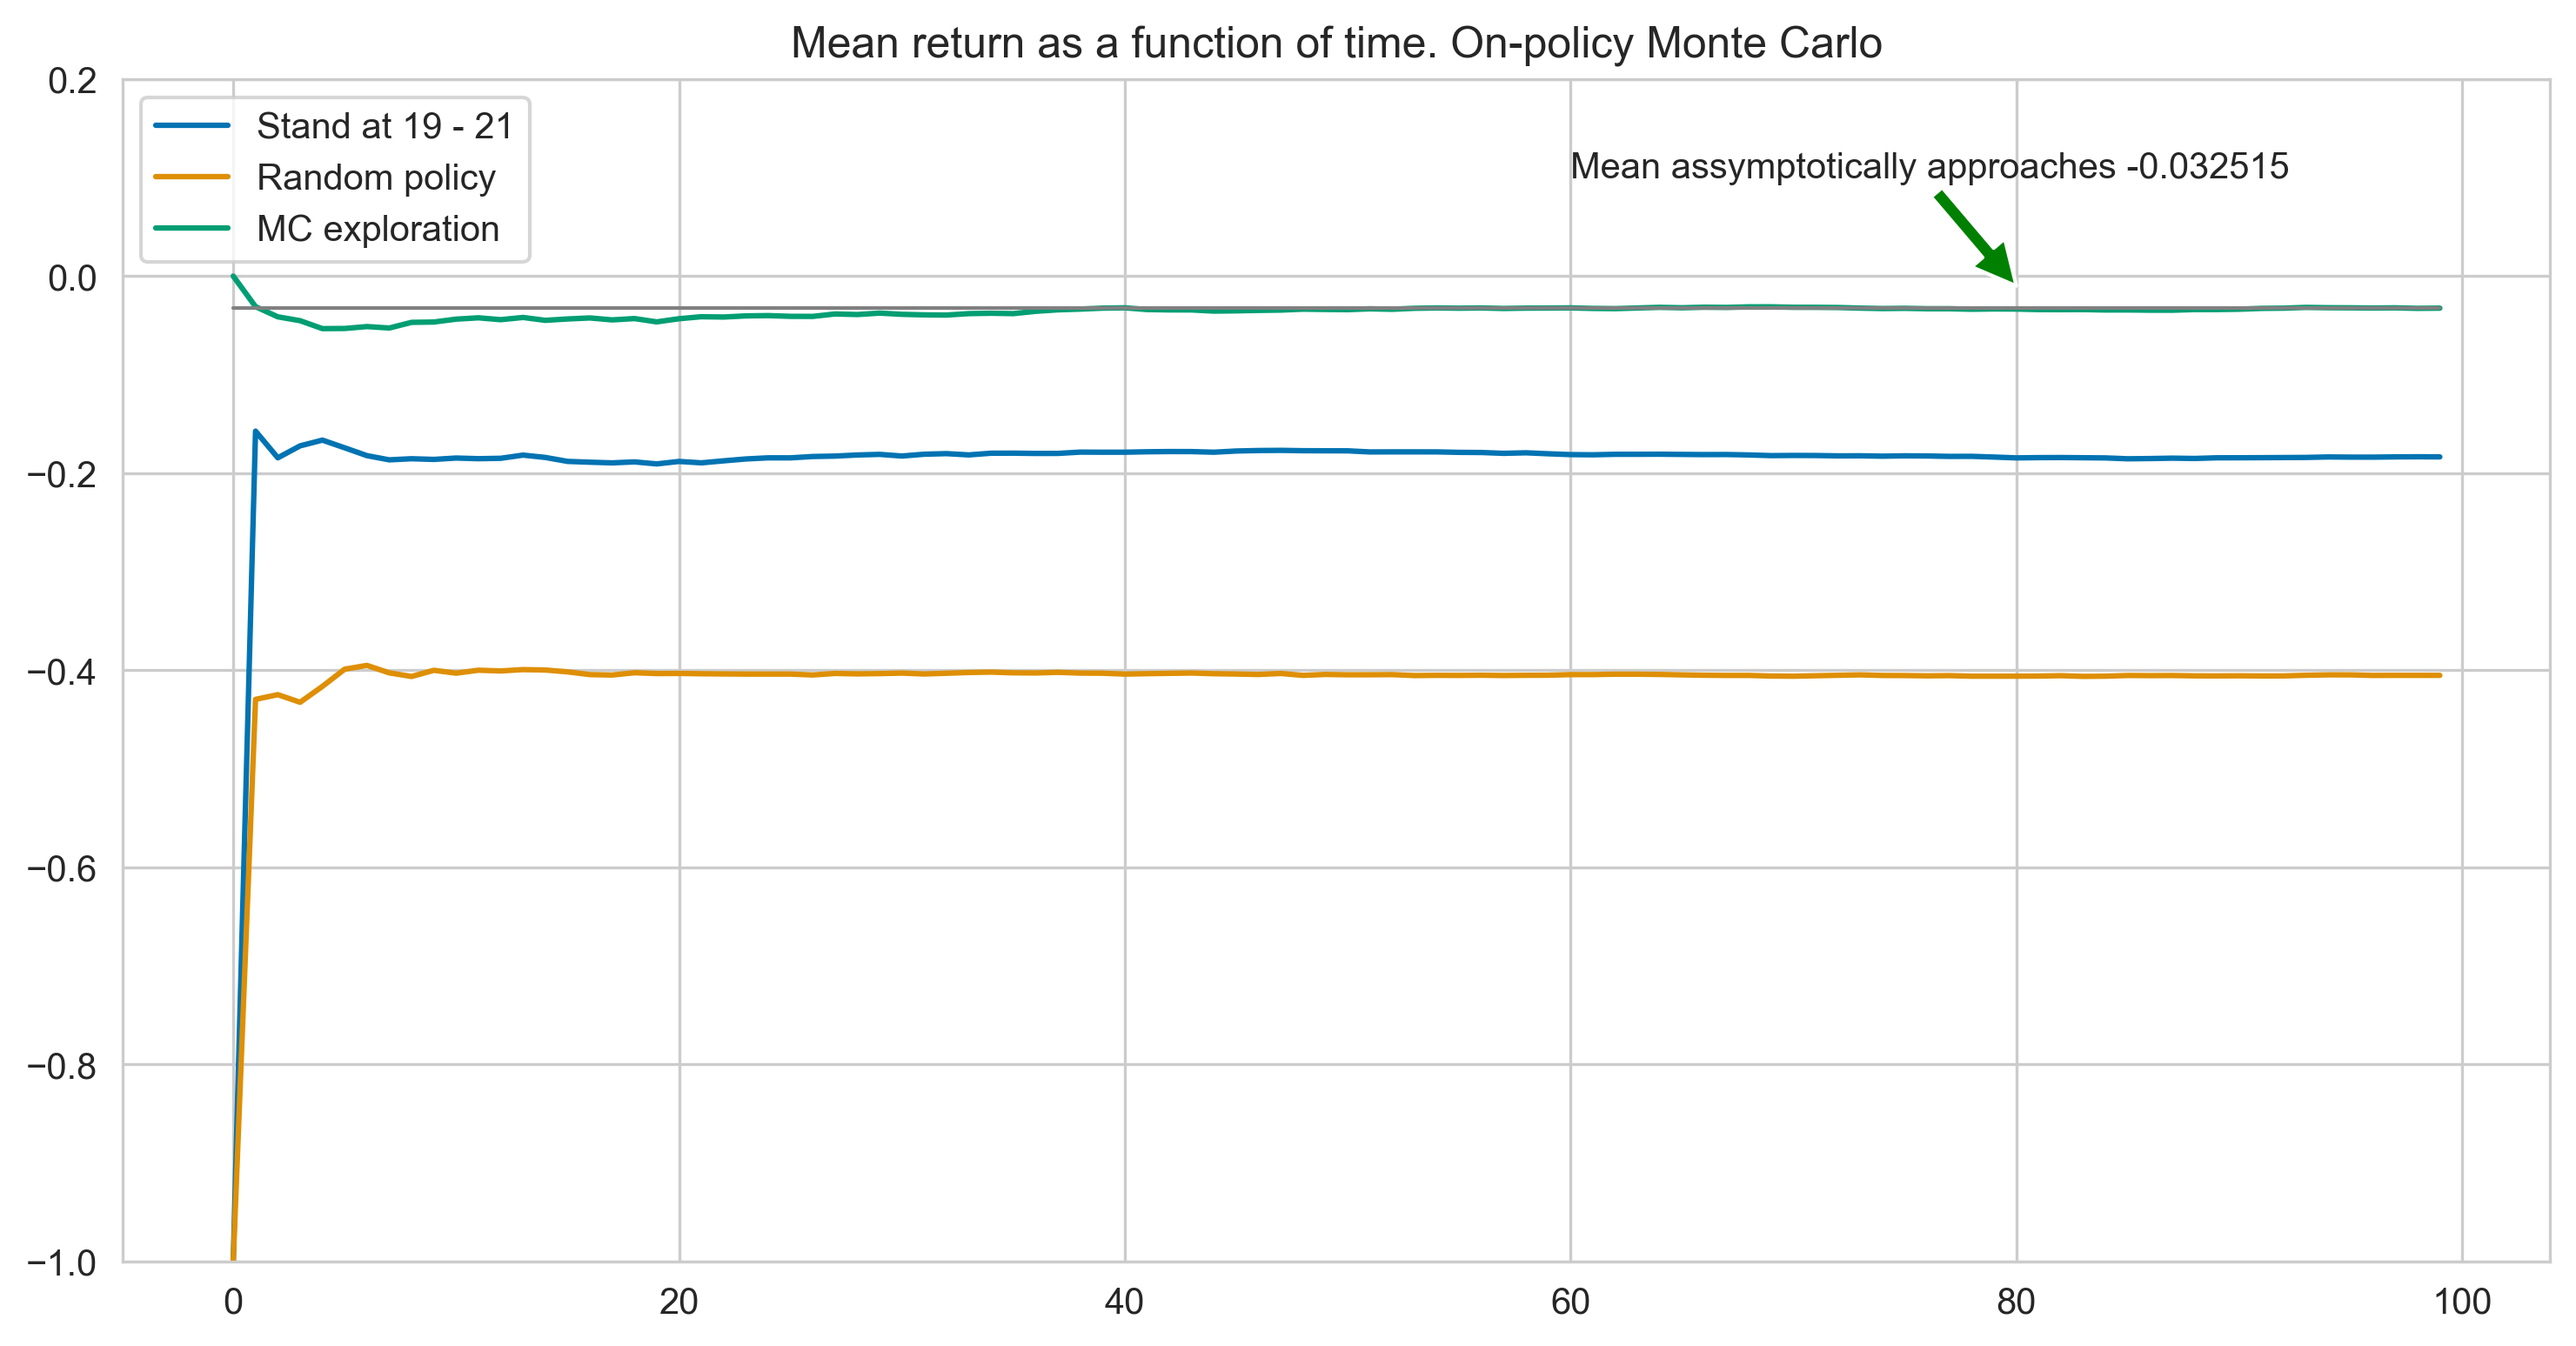

In [43]:
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='MC exploration')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.title('Mean return as a function of time. On-policy Monte Carlo')
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, -0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

Сохранил также и такой результат, который получился на обучении на 200000 эпизодов:

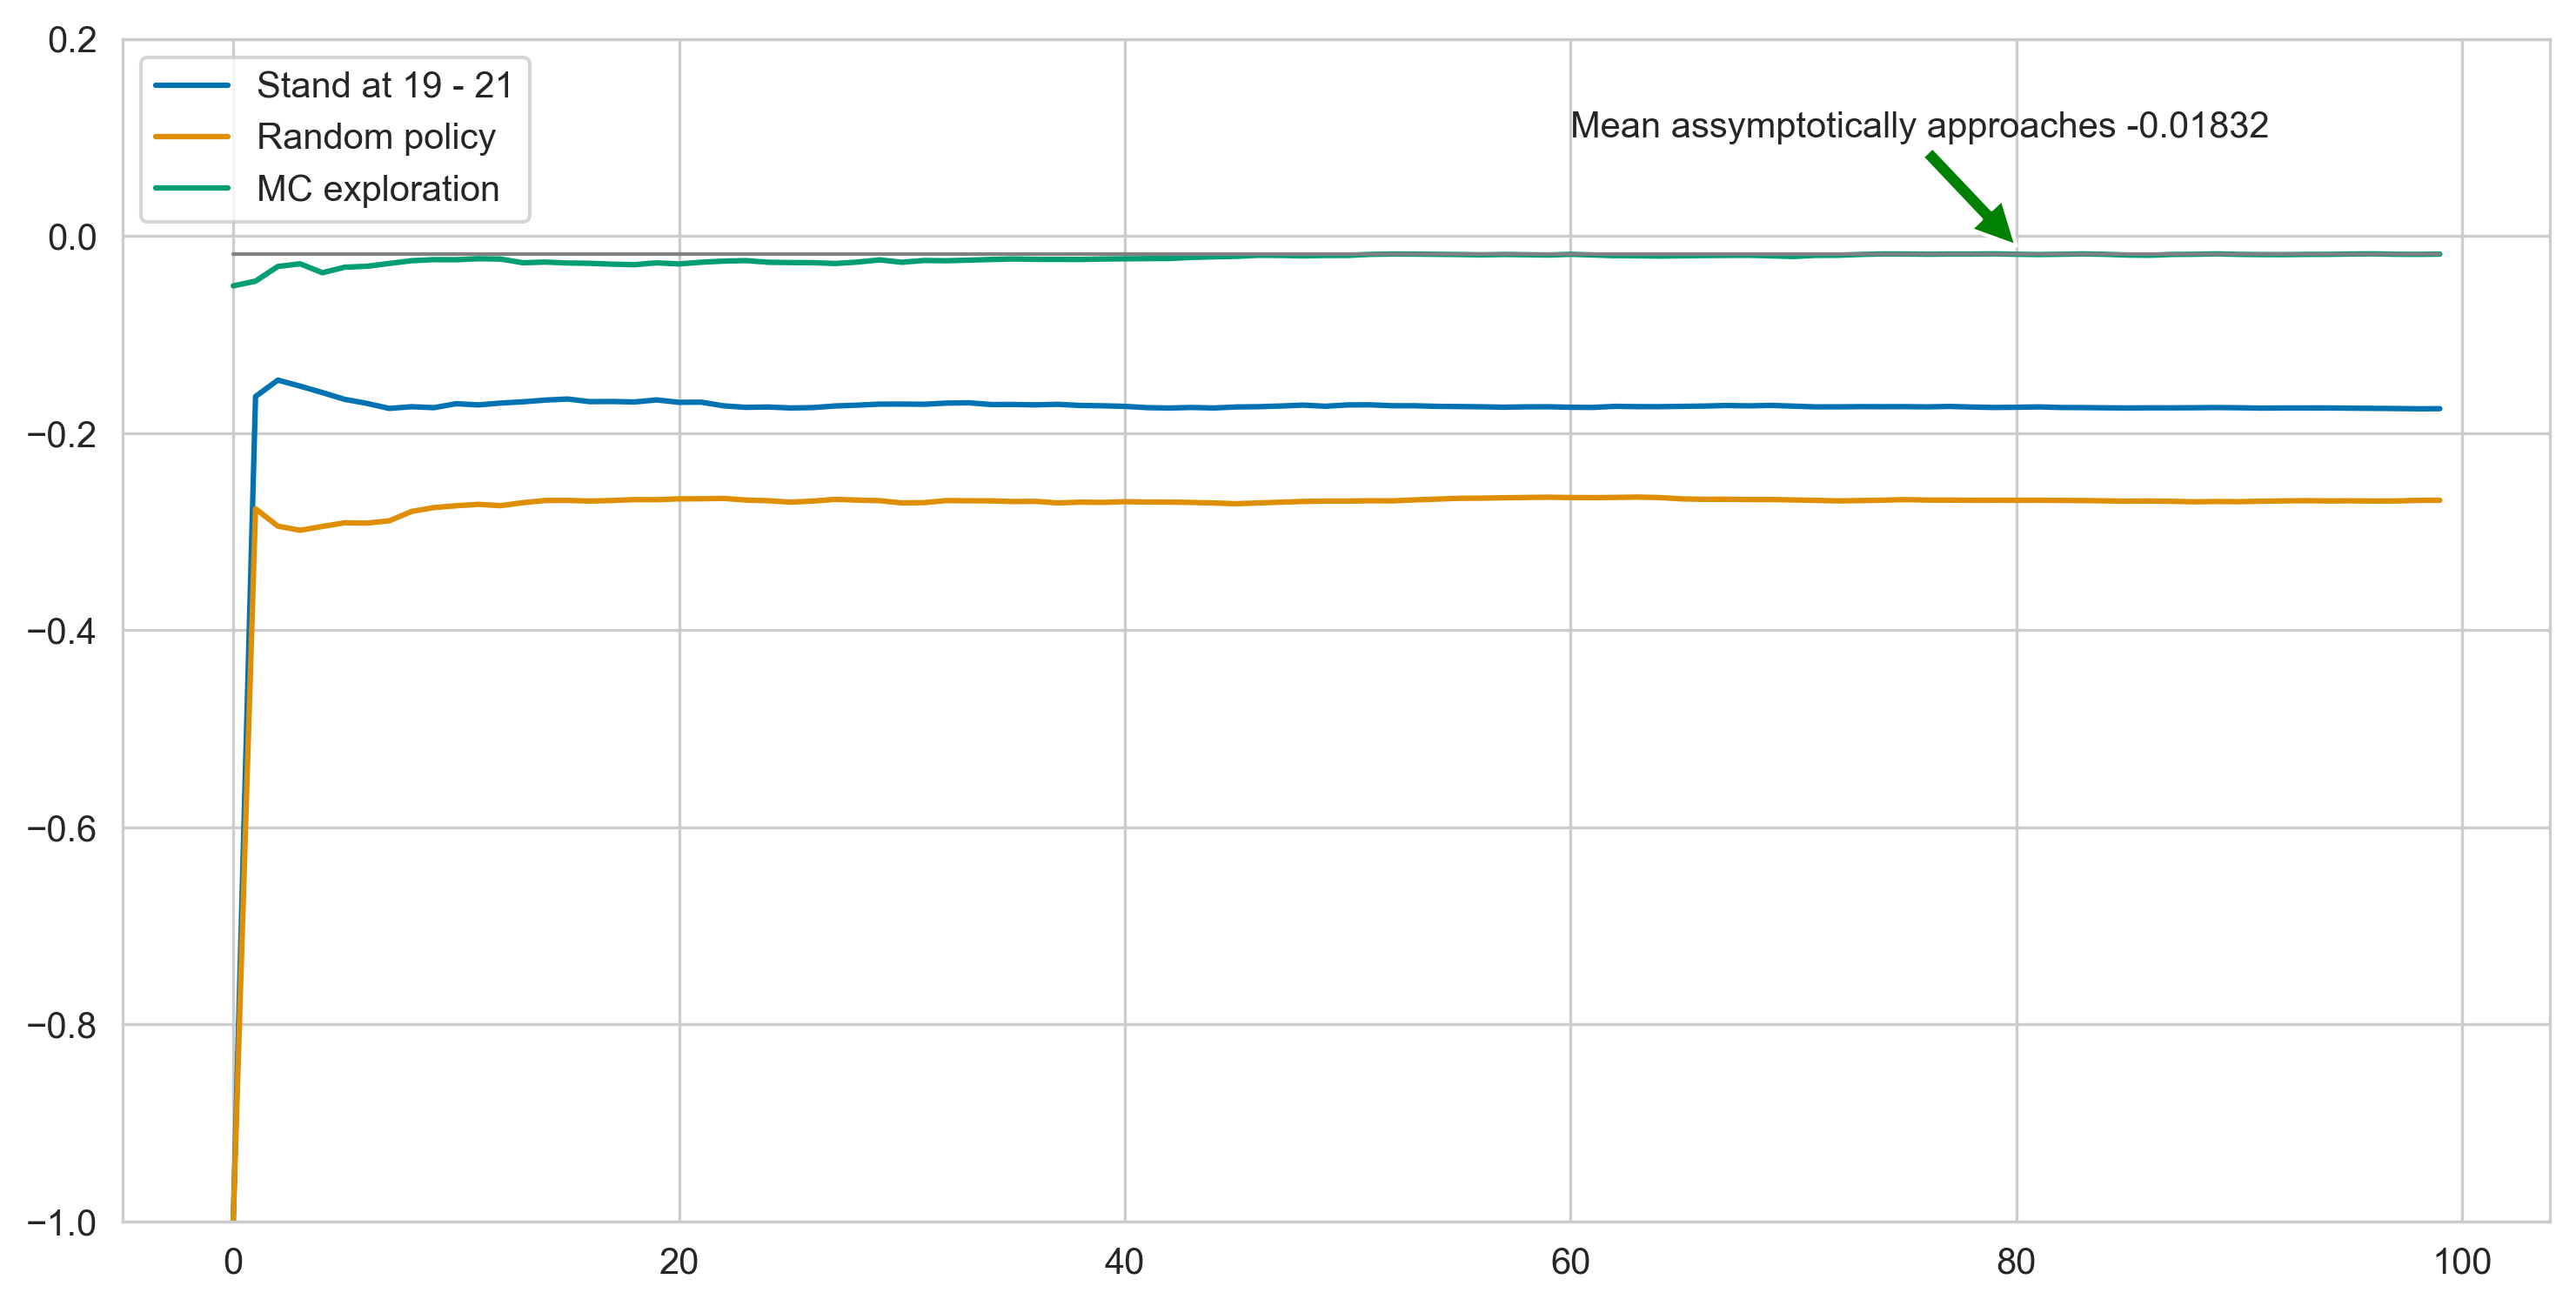

In [417]:
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='MC exploration')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.title('Mean return as a function of time. On-policy Monte Carlo')
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, -0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

$\textbf{Б) Решение методом Q-learning:}$

In [44]:
def Q_learning_double_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=1.0):
    
    (player, dealer, _) = env.reset()
    count = max(min(env.count, 10), -10)
    game_over = env.done

    if game_over:
        reward = env.reward
        s = to_mem_state(player, dealer, count)
        s_prime = to_mem_state(22, dealer, count)
        Q[s][0] = Q[s][0] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][0])
        return
    
    s = to_mem_state(player, dealer, count)
    a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

    while not game_over:
        (player, dealer, _), reward, game_over, _ = env.step(a)
        count = max(min(env.count, 10), -10)
        player = min(22, player)
        s_prime = to_mem_state(player, dealer, count)
        a_prime = pi[s_prime] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
    
    return

In [45]:
env = BlackjackMemorizeEnv()
total_episodes = 500000
gamma = 1.

Q = np.zeros((nS, nA))
pi = compute_policy_by_Q(Q)

for n in tqdm(range(total_episodes)):
    Q_learning_double_episode(env, pi, Q, alpha=0.001, epsilon= 0.2, gamma=1.)
    pi = compute_policy_by_Q(Q)
    
env.close()

  0%|          | 0/500000 [00:00<?, ?it/s]

In [46]:
mean_returns = get_mean_return(env, pi)

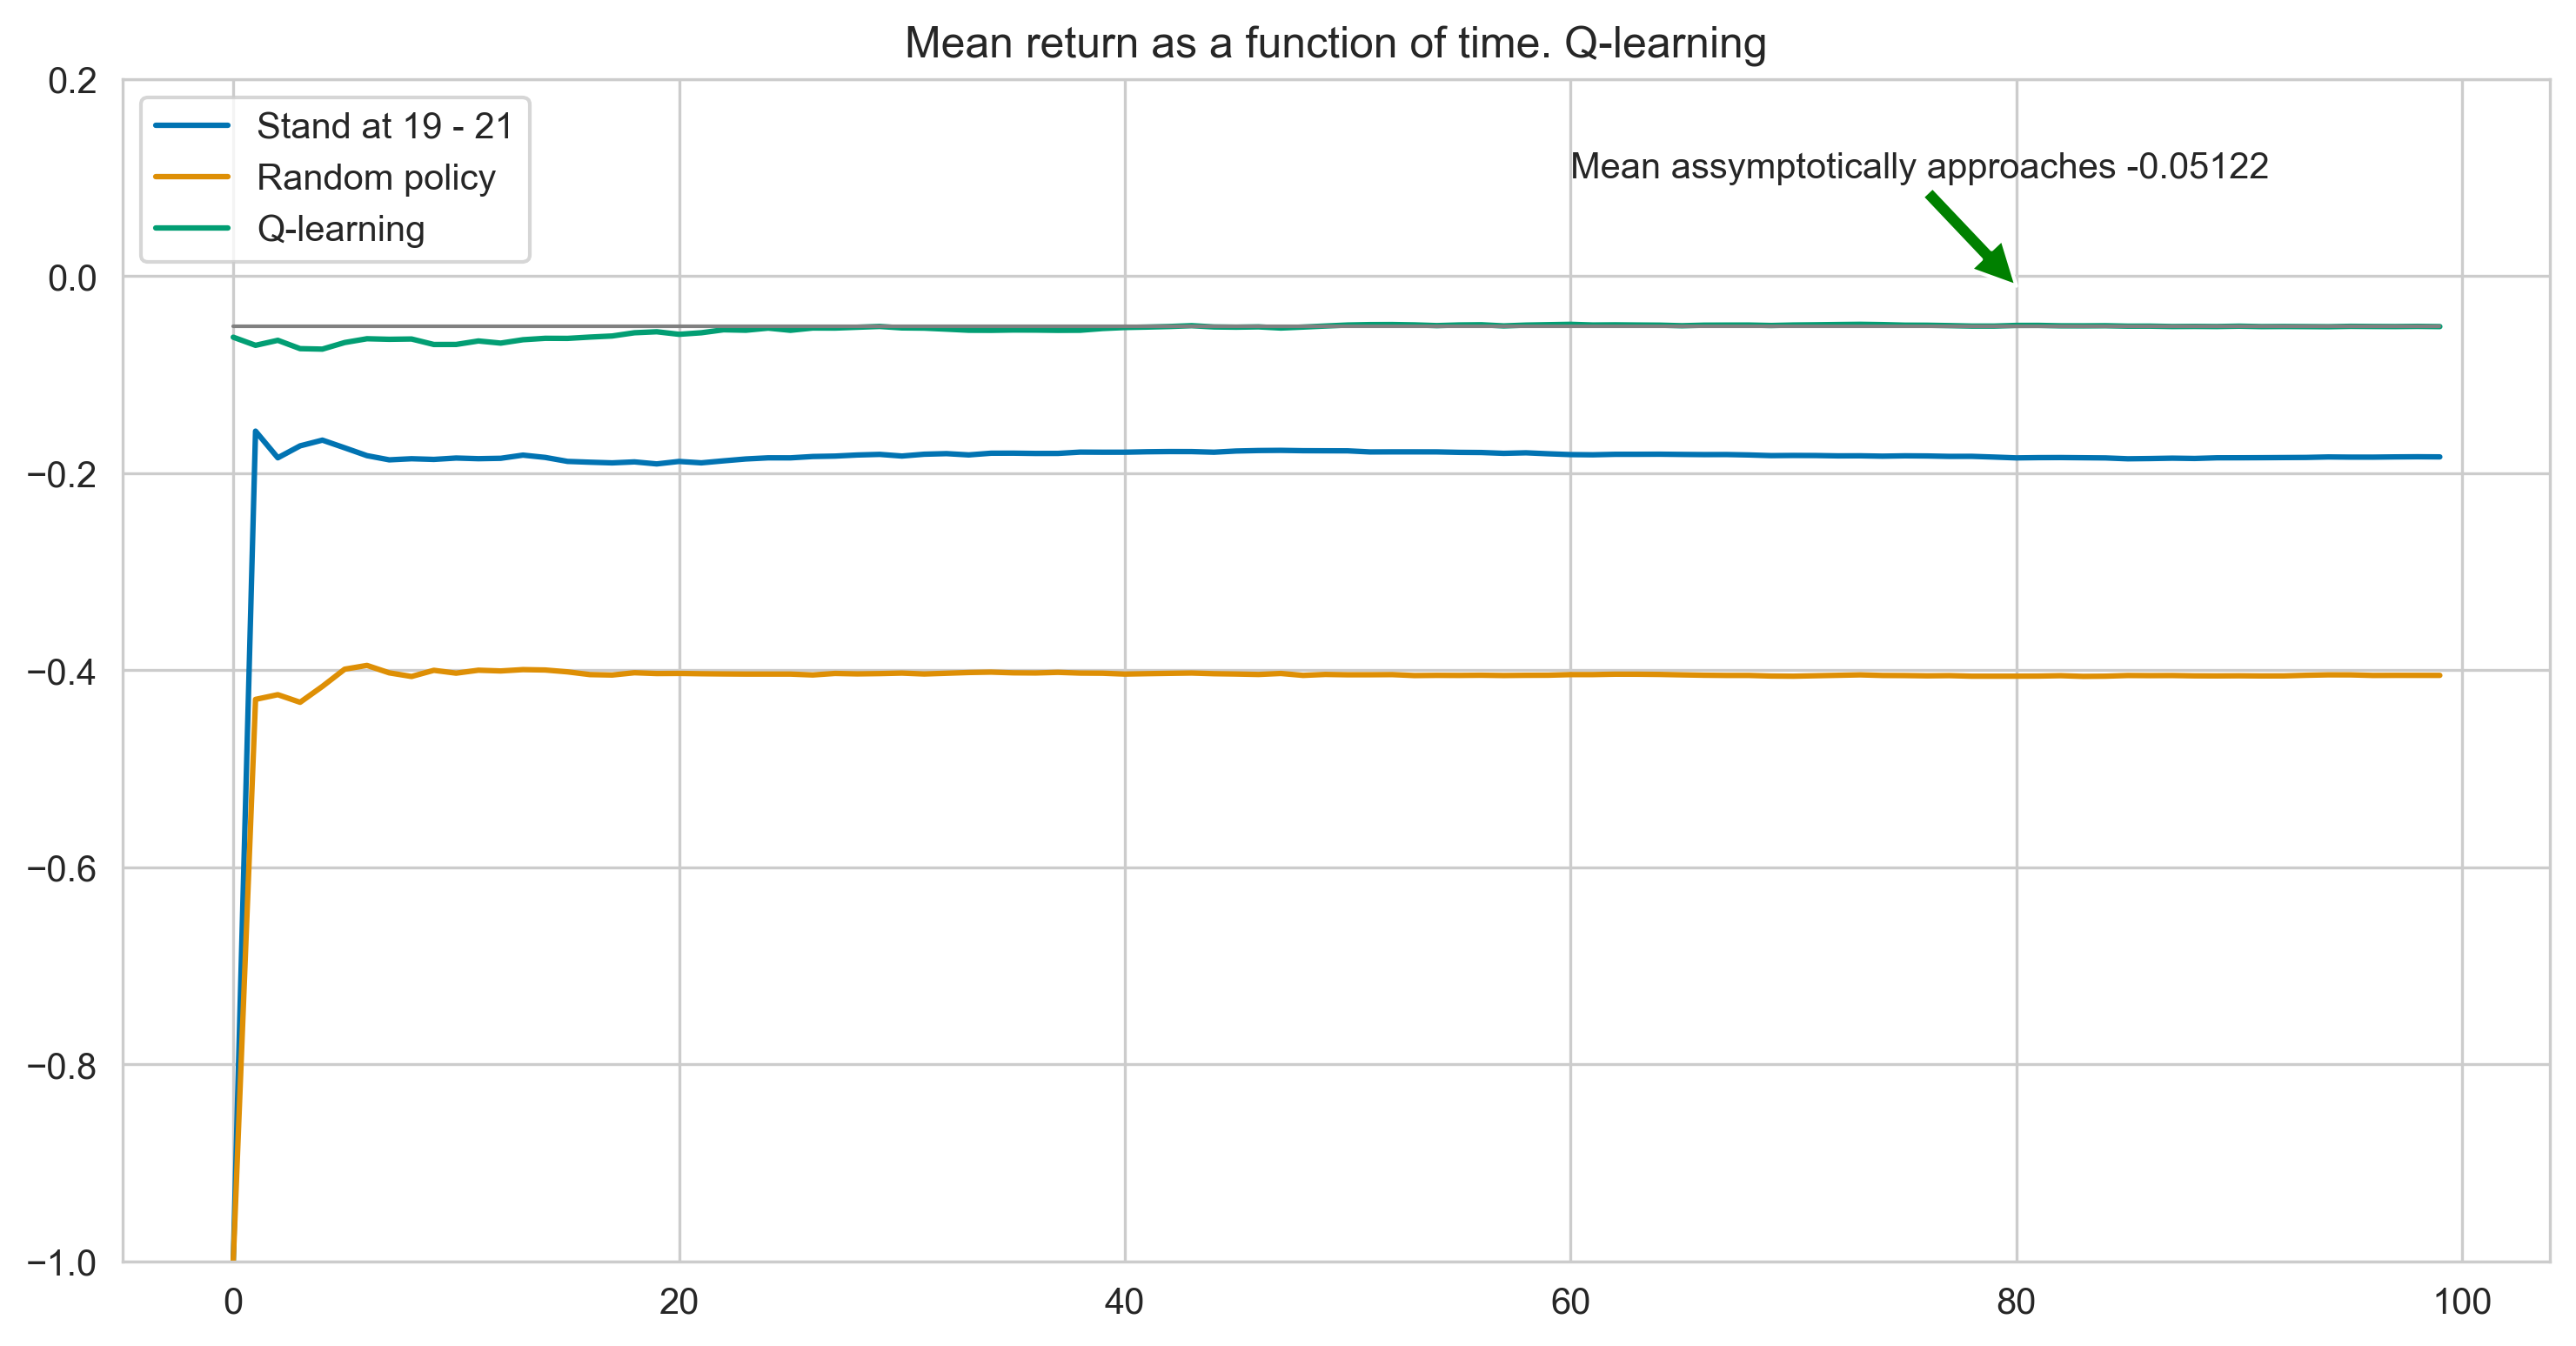

In [48]:
plt.figure(figsize=(12, 6))
plt.ylim(-1, 0.2)
plt.plot(range(100), deterministic_returns, label='Stand at 19 - 21')
plt.plot(range(100), random_means, label='Random policy')
plt.plot(range(100), mean_returns, label='Q-learning')
plt.plot(range(100), [mean_returns[-1]] * 100, 'grey', linewidth=1)
plt.title('Mean return as a function of time. Q-learning')
plt.annotate(f'Mean assymptotically approaches {mean_returns[-1]}', xy=(80, -0.01), 
             xytext=(60, 0.1),
            arrowprops=dict(facecolor='g'))
plt.legend(loc='upper left')
plt.show()

Общее заключение:

In [49]:
agg_results = pd.DataFrame({'Regular blackjack': [-0.04218, -0.08038], 
                            'Double blackjack': [-0.03624, -0.07938],
                            'Cards counting': [-0.01832, -0.05122]}, index=['MC', 'Q-TD(0)'])
agg_results

,Regular blackjack,Double blackjack,Cards counting
MC,-0.04218,-0.03624,-0.01832
Q-TD(0),-0.08038,-0.07938,-0.05122
